In [1]:
from os import access
import pandas as pd
import numpy as np
import datetime
from pandas.core.reshape.concat import concat
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from datetime import date, datetime,timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
!pip install haversine
import haversine as hs
from itertools import permutations, combinations
import geopandas as gpd

You should consider upgrading via the '/Users/anbouckaert/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping EmployeeData (HVC_AM0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

#Reading the file and storing each line in the list text
with open ("./Data/HVC_AM0.csv", "r") as f:
    textEmployees = f.readlines()
textEmployees.pop(0)

#We make a dictionnary based on the data
CompanyEmployeesDict = {}

for e in textEmployees:
    Employee_ID, EmployeeNumber, Name, Postcode, Location, Language = e.replace("\n","").split(";")
    Employee_ID=int(Employee_ID)
    Postcode=int(Postcode)
    CompanyEmployeesDict[Employee_ID]= {"EmployeeNumber":EmployeeNumber,"Name": Name, "Postcode": Postcode, "Location": Location,"Language": Language }


#Some Employees do not have a EmployeeNumber: We set the EmployeeNumber of these employees to 0
#In this way we can convert all to a float
for e in CompanyEmployeesDict:
    E_ID = CompanyEmployeesDict[e]["EmployeeNumber"]
    if(E_ID == ""):
        CompanyEmployeesDict[e]["EmployeeNumber"]="0"
    CompanyEmployeesDict[e]["EmployeeNumber"] = int(float(CompanyEmployeesDict[e]["EmployeeNumber"]))   

df_CompanyEmployees = pd.DataFrame.from_dict(CompanyEmployeesDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping ProductData (HVC_AR0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("./Data/HVC_AR0.csv", "r") as f:
    textProducts = f.readlines()
textProducts.pop(0)

CompanyProductsDict = {}
for e in textProducts:
    ProductID, Description, Category, Family, Price = e.replace("\n","").split(";")
    ProductID = int(ProductID)
    CompanyProductsDict[ProductID]= {"Description":Description,"Category": Category, "Family": Family, "Price": Price}
   
#Some prices are missing   
for e in CompanyProductsDict:
  PriceCheck = CompanyProductsDict[e]["Price"]
  if(PriceCheck==""):
        CompanyProductsDict[e]["Price"]="0.0"
  CompanyProductsDict[e]["Price"]=float(CompanyProductsDict[e]["Price"])  

#Whenever they are Coupons they are not assigned a family
#We assign Coupon to its Family for clearity
for e in CompanyProductsDict:
  PriceCheck = CompanyProductsDict[e]["Family"]
  if(PriceCheck==""):
        CompanyProductsDict[e]["Family"]="Coupon"

df_Products = pd.DataFrame.from_dict(CompanyProductsDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Reviews Data (HVC_CUSTOMER_REVIEWS)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------   


with open ("./Data/HVC_CUSTOMER_REVIEWS.csv", "r") as f:
    textCustReviews = f.readlines()
textCustReviews.pop(0)

CompanyReviewsDict = {}
for e in textCustReviews:
    CustomerID, Review  = e.replace("\n","").split(";")
    CustomerID = int(CustomerID)
    CompanyReviewsDict[CustomerID]= {"Review": Review}

df_Reviews = pd.DataFrame.from_dict(CompanyReviewsDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Depot data (HVC_DEPOT)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("./Data/HVC_DEPOT.csv", "r") as f:
    text_Depot = f.readlines()
text_Depot.pop(0)

#We make a dictionnary based on the data
Depot_Dict = {}

for dep in text_Depot:
    Depot_Id, Depot_Location, Depot_Route = dep.replace("\n","").split(";")
    Depot_Id = int(Depot_Id)
    Depot_Route = int(Depot_Route)
    Depot_Dict[Depot_Id] = {"DEPOT":Depot_Location, "HVROUTETEMPLATE_NRID":Depot_Route}

#The Depot_Id and HVROUTETEMPLATE_NRID are both integers, Depot_Location
#The names of the keys are based on the table descriptions for easy looking up in case of further calculations
#There are no missing values in our dictionnary so further preprocessing is not necessary.

df_Depot = pd.DataFrame.from_dict(Depot_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping DaysOfWeek (HVC_HVDAYOFWEEK)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("./Data/HVC_HVDAYOFWEEK.csv", "r") as f:
    text_DayOfWeek = f.readlines()
text_DayOfWeek.pop(0)

#We make a dictionnary based on the data
DayOfWeek_Dict = {}

for day in text_DayOfWeek:
    HVDAYOFWEEK_NRID, DAY = day.replace("\n","").split(";")
    HVDAYOFWEEK_NRID = int(float(HVDAYOFWEEK_NRID))
    DayOfWeek_Dict[int(HVDAYOFWEEK_NRID)] = DAY


#The HVDAYOFWEEK_NRID is an integer, DAY is a string. 
#!! important notice for further caclulations, the first day (day with id = 1) is a sunday! Not a monday!
df_DaysOfWeek = pd.DataFrame.from_dict(DayOfWeek_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Position data (HVC_HVPOSITION)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("./Data/HVC_HVPOSITION.csv", "r") as f:
    text_Position = f.readlines()
text_Position.pop(0)

#We make a dictionnary based on the data
Position_Dict = {}

for loc in text_Position:
    SO0_NRID, LONG, LAT = loc.replace("\n","").split(";")
    SO0_NRID = int(float(SO0_NRID))
    LONG = float(LONG)
    LAT = float(LAT)
    Position_Dict[SO0_NRID] = {"LONG":LONG, "LAT":LAT}

#SO0_NRID is int, LONG and LAT are both float values.

df_Position = pd.DataFrame.from_dict(Position_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Route Template data (HVC_HVROUTETEMPLATE)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("./Data/HVC_HVROUTETEMPLATE.csv", "r") as f:
    textRouteTemplate = f.readlines()
    textRouteTemplate.pop(0)
    
RouteTemplate_Dict = {}

for route in textRouteTemplate:
    HVROUTETEMPLATE_NRID, REGION, WEEKORDER, HVDAYOFWEEK_NRID = route.replace("\n","").split(";")
    HVROUTETEMPLATE_NRID=int(float(HVROUTETEMPLATE_NRID))
    RouteTemplate_Dict[HVROUTETEMPLATE_NRID] = {"REGION": REGION, "WEEKORDER": WEEKORDER, "DAYOFWEEK_NRID": HVDAYOFWEEK_NRID}        

df_RouteTemplate = pd.DataFrame.from_dict(RouteTemplate_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Visit Outcome data (HVC_HVVISITOUTCOME)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("./Data/HVC_HVVISITOUTCOME.csv", "r") as f:
    textVisitOutcome = list()
    for line in f:
        line = line.replace("\n","")
        obs = line.split(";")
        textVisitOutcome.append(obs)

column_names = textVisitOutcome[0]
textVisitOutcome.pop(0)
VisitOucome_Dict = {}

for visit in textVisitOutcome:
    VisitOucome_Dict[visit[1]] = visit[0]


df_VisitOutcome = pd.DataFrame.from_dict(VisitOucome_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping TransactionData (HVC_HVVISITRESULT)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("./Data/HVC_HVVISITRESULT.csv", "r") as f:
    textVisit = f.readlines()
textVisit.pop(0)

#We make a dictionnary based on the data
CompanyVisitDict = {}

for e in textVisit:
    Visit_ID, Customer_ID, Employee_ID, VisitOutcome_ID, Time, Date, Amount, paymentMethod = e.replace("\n","").split(";")
    Visit_ID= int(Visit_ID)

    yYear, mMonth, dDay = Date.split("-")
    yYear = int(yYear)
    mMonth = int(mMonth)
    dDay = int(dDay)
    Date=date(yYear,mMonth,dDay)

    Customer_ID= int(Customer_ID)
    Employee_ID= int(Employee_ID)
    VisitOutcome_ID= int(VisitOutcome_ID)
    Amount= float(Amount)
    CompanyVisitDict[Visit_ID]= {"Customer_ID":Customer_ID,"Employee_ID": Employee_ID, "VisitOutcome_ID": VisitOutcome_ID, "Time": Time,"Date": Date, "Amount": Amount, "paymentMethod": paymentMethod }

#Some visits do not have a payment method recorded: We set the paymentMethod of these cases to the None variable
#Maybe these missing values will have value later on
for e in CompanyVisitDict:
    P_method = CompanyVisitDict[e]["paymentMethod"]
    if(P_method == ""):
        CompanyVisitDict[e]["paymentMethod"]= None

df_CompanyVisit = pd.DataFrame.from_dict(CompanyVisitDict, orient = 'index')

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping EmployeeData (HVC_SO0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("./Data/HVC_SO0.csv", "r") as f:
    textCustomerType = f.readlines()
textCustomerType.pop(0)

#We make a dictionnary based on the data
CustomerTypeDict = {}

for e in textCustomerType:
    Customer_ID, RouteTemplate_ID, CustomerType, Postcode, Language, Season = e.replace("\n","").split(";")
    Customer_ID=int(float(Customer_ID))
    RouteTemplate_ID=int(float(RouteTemplate_ID))
    Postcode = int(float(Postcode))
    CustomerTypeDict[Customer_ID]= {"RouteTemplate_ID":RouteTemplate_ID,"CustomerType": CustomerType, "Postcode": Postcode, "Language": Language,"Season": Season}


df_CustomerType = pd.DataFrame.from_dict(CustomerTypeDict, orient = 'index')

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping ProductData (HVC_VISITRESULTDETAILS)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("./Data/HVC_VISITRESULTDETAILS.csv", "r") as f:
    textVisitDetails = f.readlines()
textVisitDetails.pop(0)


#We make a dictionnary based on the data
VisitDetailsDict = {}


for e in textVisitDetails:
    VisitDetails_ID, Product_ID, Quantity, Visit_ID = e.replace("\n","").split(";")
    VisitDetails_ID=int(VisitDetails_ID)
    Product_ID=int(Product_ID)
    Quantity=int(float(Quantity))
    Visit_ID=int(float(Visit_ID))
    VisitDetailsDict[VisitDetails_ID]= {"Product_ID":Product_ID,"Quantity": Quantity, "Visit_ID": Visit_ID}

df_VisitDetails = pd.DataFrame.from_dict(VisitDetailsDict, orient = 'index')

#We add a a selfmade database of average and median household income per postal code, the document is called Income_per_postcode2.csv
df_Income_per_postcode = pd.read_csv("./Data/Income_per_postcode2.csv")
#This dataframe may be important for several regressions questions 


#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#This gives us the following 11 dataframes to work with:
# 1  df_CompanyEmployees (HVC_AM0)
# 2  df_Products (HVC_AR0)
# 3  df_Reviews  (HVC_CUSTOMER_REVIEWS)
# 4  df_Depot  (HVC_DEPOT)
# 5  df_DaysOfWeek (HVC_HVDAYOFWEEK)
# 6  df_Position (HVC_HVPOSiTION)
# 7  df_RouteTemplate (HVC_HVROUTETEMPLATE)
# 8  df_VisitOutcome (HVC_HVVISITOUTCOME)
# 9  df_CompanyVisit (HVC_VISITRESULT)
# 10 df_CustomerType (HVC_SO0)
# 11 df_VisitDetails (HVC_VISITRESULTDETAILS)
# 12 df_Income_per_postcode (Income_per_postcode2, data source link: https://statbel.fgov.be/nl/themas/huishoudens/fiscale-inkomens#panel-13 )",
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
###########################
#Q1: What are the Products?
###########################

In [7]:
#Q1.1 What are the most frequently bought products?
#Firstly we construct a new dataframe Aureum: in this dataframe
#We sum all quantities over it's unique product_ID
#in this way we get the total amount a certain product/product_ID is bought
#over all visits
Aureum = df_VisitDetails.groupby("Product_ID")["Quantity"].sum()
#Next we merge this dataframe with df_products so we can get the description
#Family and all other information on every single Product_ID
#This is a left merge since some Products might not have been bought during visits
#And in this way we can prevent NAN
newAU = pd.merge(Aureum, df_Products, how="left", on=Aureum.keys())

#We make a new Column Revenue: This is the price of a product multiplied by the 
#Quantity the product has sold for: giving us the complete revenue of a specified product
#This is used in later questions
Revenue = newAU["Price"]*newAU["Quantity"]
#We add this column to the newAu dataframe
newAU["RevenueProduct"] = Revenue


#In order to get the most sold products: we sort on Quantity giving the most sold
#products with their description on top
#The anwser to this question can be found by printing the head of this dataframe
#Worst products can be found by looking at the tail
BestAmountSoldProducts = newAU.sort_values(by="Quantity", ascending=False)

print(BestAmountSoldProducts.drop(columns=["Product_ID","Price","RevenueProduct","key_0"]).head(10))

       key_0  Quantity          Description         Category     Family  \
1      23678     12051           Penalty/16  Verkoopsartikel   Hand Ice   
29     23716      8725      Chocolademousse  Verkoopsartikel      Meals   
7      23685      7661  Icy Stick Vanille/6  Verkoopsartikel   Hand Ice   
40     23734      4345        Magic Choc/12  Verkoopsartikel   Hand Ice   
120  8609011      3210   Grove Horentjes/40  Verkoopsartikel  Garniture   

     Price      Product_ID  RevenueProduct  
1      6.5  20413488326838         78331.5  
29     6.5        59894425         56712.5  
7      6.1  17105588295040         46732.1  
40     9.5        51717887         41277.5  
120    3.6           23829         11556.0  
     Quantity                     Description         Category  \
1       12051                      Penalty/16  Verkoopsartikel   
29       8725                 Chocolademousse  Verkoopsartikel   
7        7661             Icy Stick Vanille/6  Verkoopsartikel   
40       4345  

In [5]:
#Q1.2 Which products render the most revenue?
#For this we use the added revenue column on newAU from Question 1.1
#By sorting on this column and putting ascending to False
#We get the products with their description with the best revenue on top
#The anwser can be found by printing the head of this dataframe
BestRevProducts = newAU.sort_values(by="RevenueProduct", ascending=False)

print(BestRevProducts.head(12))

              key_0  Quantity                     Description  \
1             23678     12051                      Penalty/16   
29            23716      8725                 Chocolademousse   
7             23685      7661             Icy Stick Vanille/6   
40            23734      4345                   Magic Choc/12   
90            23823      2399         Konijn op vlaamse wijze   
305  21792988536842      2659    Duette Van/Choc 24 x 120 ml.   
33            23721      2987        Sint Jacobsschelp 2x150g   
293  21124152356448      1898        Subimba 80 cc.Vanille/48   
41            23735      2066               Icy Chocolade /24   
27            23714      3108  Grand Marnier cuvee speciale /   
18            23699      1959          Scampi Pil Pil 2x150gr   
8             23686      2061      Peep-up roze pompelmoes/16   

            Category              Family  Price  RevenueProduct  
1    Verkoopsartikel            Hand Ice    6.5         78331.5  
29   Verkoopsartikel  

In [6]:
#Q1.3 Which products are bought the most in the region of Brussels, Antwerp, …?
###########################################""
#IMPORTANT THIS CODE HAS TO BE RUN TWICE
##########################################
# merge routetemplate and depot to see if the region code and depot location are connected
# first we define the keys of the Route Template dataframe as an extra column so they can be accessed
# then we give the keys of the depot an appropriate name in order to merge them with more convenience
df_RouteTemplate["RouteTemplate_ID"] = df_RouteTemplate.index
df_Depot["RouteTemplate_ID"] = df_Depot["HVROUTETEMPLATE_NRID"]
RouteTemplate_with_DepotLocation = pd.merge(df_RouteTemplate, df_Depot, how = "inner", on = "RouteTemplate_ID")
RouteTemplate_with_DepotLocation.head(5)

# out of the previous dataframe it becomes clear that the location of the depot and the region code are not always 
# the same for each location
# now we are going to create a dataframe in which the quantity of the products sold and the location of the depot
# are both present, therefore we have to merge multiple dataframes
Customer_with_DepotLocation = pd.merge(df_CustomerType, RouteTemplate_with_DepotLocation, how = "inner", on = "RouteTemplate_ID")
Customer_with_DepotLocation

# To merge the following dataframes, we first need to create an extra column with the customer ID's 
# for the CustomerType so they can be accessed in the future, the same goes for the Visit_ID of CompanyVisit
# and the product_ID of products
df_CustomerType["Customer_ID"] = df_CustomerType.index
df_CompanyVisit["Visit_ID"] = df_CompanyVisit.index
df_Products["Product_ID"] = df_Products.index

# merge the Customer_with_DepotLocation dataframe with the results of the visit (= dataframe CompanyVisit)
Visit_with_DepotLocation = pd.merge(Customer_with_DepotLocation, df_CompanyVisit, how = "inner", on = "Customer_ID")
Visit_with_DepotLocation

# now we are going to merge this dataframe, with the VisitDetails dataframe in order to gain information about the
# product_ID's and the quantities sold
Quantity_with_DepotLocation = pd.merge(Visit_with_DepotLocation, df_VisitDetails, how = "inner", on = "Visit_ID")

# here we already are going to look in which depots the most quantities are sold
Quantity_with_DepotLocation.groupby("DEPOT")["Quantity"].sum()

# Now we are going to look which products are most sold in which region?
# probleem hier nog: als regio heb ik gewoon de locaties van de depots genomen, maar in de vraag staat er ook Brussel
# en andere steden, dus meer dan enkel de depots
# zou ik dan postcodes moeten gaan verwerken naar regio's of die region codes gaan ontcijferen?
# with the location of the depots I worked as followed:
# 1) first I merged the previous dataframe Quantity_with_DepotLocation with df_Products on product_ID in order to
# get more information about the product and its description
# 2) then i created 4 subsamples (= the four locations of the depots)
# 3) i looked in every dataframe which product was sold how many times by grouping the dataframe by 
# its product_ID and taking the sum of the quantities and stored this data per location/sub_dataframe
# 4) Next we merge this dataframe with df_products so we can get the description
# Family and all other information on every single Product_ID

# 1) 
Products_with_DepotLocation_1 = pd.merge(Quantity_with_DepotLocation, df_Products, how = "inner", on = "Product_ID")
Products_with_DepotLocation_1

# 2)# make a subselection of the dataframe based on the location of the depot
df_Deinze = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Deinze"]
df_Aarschot = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Aarschot"]
df_Antwerpen = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Antwerpen"]
df_Vilvoorde = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Vilvoorde"]

# 3 + 4) 

product_quantities_Deinze = df_Deinze.groupby("Product_ID")["Quantity"].sum()
df_Products_Deinze = pd.merge(product_quantities_Deinze, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Deinze.sort_values(by = "Quantity", ascending = False).head(10))

product_quantities_Aarschot = df_Aarschot.groupby("Product_ID")["Quantity"].sum()
df_Products_Aarschot = pd.merge(product_quantities_Aarschot, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Aarschot.sort_values(by = "Quantity", ascending = False))

product_quantities_Antwerpen = df_Antwerpen.groupby("Product_ID")["Quantity"].sum()
df_Products_Antwerpen = pd.merge(product_quantities_Antwerpen, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Antwerpen.sort_values(by = "Quantity", ascending = False))

product_quantities_Vilvoorde = df_Vilvoorde.groupby("Product_ID")["Quantity"].sum()
df_Products_Vilvoorde = pd.merge(product_quantities_Vilvoorde, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Vilvoorde.sort_values(by = "Quantity", ascending = False))




KeyError: 'Customer_ID'

In [37]:
#Q1.4 Are product purchases correlated? Are some products often purchased together?

# To answer this question, we will first merge the dataset

df_visit_products = pd.merge(df_Products, df_VisitDetails, how = "inner", on = "Product_ID")
df_visit_products

# create a function that finds pairs in the purchased products and list 
# and list them in a column, using A and B as stand-in
def find_pairs(x):
    pairs = pd.DataFrame(list(permutations(x.values, 2)), columns = ["A", "B"])
    return pairs

# group the products by Visit_ID and then apply the function
# THIS TAKES 5 MIN to run
dataset_combo = df_visit_products.groupby("Visit_ID")["Description"].apply(find_pairs).reset_index(drop = True)
dataset_combo.head()

# Calculate how often each pair dus occur
dataset_combo2 = dataset_combo.groupby(["A", "B"]).size()
dataset_combo2

# create a sorted dataframe by the most frequent combinations
most_frequent_combinations = dataset_combo2.reset_index()
most_frequent_combinations.columns = ["A", "B", "Size"]
most_frequent_combinations.sort_values(by = "Size", ascending = False, inplace = True)
most_frequent_combinations.head(5)

# now we are going to clean this dataset as there are duplicates for each row
most_frequent_combinations_clean = most_frequent_combinations.iloc[::2]
most_frequent_combinations_clean.head(15)

KeyboardInterrupt: 

In [39]:
#Q1.5 What are the total sales generated for each product family?
#Using the earlier dataframes based on quantity and revenue we can anwser these questions
#By simply grouping over each Family or Catogory and then taking the sum of either Revenue or Quanitity
#And then sorting the values to get the largest on top
#This way if we group on a family and then sum each revenue from all products for that family for example
#We can anwser the question 

#Based on Family
#Generated Revenue
BestRevFamily=BestRevProducts.groupby("Family")["RevenueProduct"].sum().sort_values(ascending=False)
#Based on Family
#Amount sold
BestAmountFamily=BestAmountSoldProducts.groupby("Family")["Quantity"].sum().sort_values(ascending=False)

#Based on Catogery
#Generated Revenue
BestRevCat=BestRevProducts.groupby("Category")["RevenueProduct"].sum().sort_values(ascending=False)

#Based on Catogery
#Amount sold
BestAmountCat=BestRevProducts.groupby("Category")["Quantity"].sum().sort_values(ascending=False)

#The anwser can be found by printing all the dataframes
#The dataframes are not big so no need to use head

print(BestRevFamily)
#print(BestRevCat)

Family
Hand Ice              294306.00
Meals                 229544.00
Cups                  129031.60
Individual Dessert    102101.70
Scoop Ice              90953.15
Coffee                 59099.80
Assortments            29391.70
Ice Cakes              25834.60
Garniture              20224.40
Coupon                 11631.60
BIG                     2764.80
POS inside              1743.00
Name: RevenueProduct, dtype: float64


In [40]:
#Q1.6 Does the weather / seasonal changes have an effect on the total revenue?
#IMPORTANT This question requires the dataFrame newAU from 1.1

#This is used to define a function that calculates which season a given date is
#This function: 'get_season' returns the season of a date
Y=2020
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

#We then apply this function on the column Date to get the Seasons
#We store the correspondent season on a new column in the dataframe: "Season"

df_CompanyVisit["Season"]=df_CompanyVisit["Date"].apply(get_season)
#By grouping on Season and taking the sum of Amounts for each season we can anwser the question
df_Seasonality=df_CompanyVisit.groupby("Season")["Amount"].sum()
#Use percentages
df_Seasonality=(df_Seasonality/df_Seasonality.values.sum())*100

#THIS IS EXPRESSED IN PERCENTAGES
print(df_Seasonality.head(5))

Season
Autumn    23.119592
Spring    29.363978
Summer    29.239115
Winter    18.277316
Name: Amount, dtype: float64


In [ ]:
##########################
#Q2 Who are the customers?
##########################

In [111]:
#Q2.1 What do customers buy?
#We decided to skip this question
#We already anwser which are the most sold products and in which seasons, which category in
#Q1. So this is already kind of what customers buy
#In later Questions in Q2 we go deeper on who the customers are: We define churners, Clusters
#buying patterns etc so this questions seemed ambigious and non-specific to us
#For an anwser we refer to the Questions from Q1 and Q2

In [41]:
#Q2.2 Which customers left the company?
#We define churn as not having bought from the company for a complete year
#We decided upon this because a whole year encompasses all seasons so
#this way we can incorprates seasonality: some might only buy in a specific season
#and we don't want to eliminate these customers

#First get the customers and their dates they visited
df_CustomersWithDates = df_CompanyVisit[["Customer_ID","Date"]]

#Get the most recent date over the whole dataframe
#This is the snapshot date of the database
mostRecent= max(df_CompanyVisit["Date"])
daysinaYear = 365

#We define the chruncap as the mostRecent date in the database
#-365 days: a year: this is considerd churn if >
ChurnCap = mostRecent - timedelta(daysinaYear)

#We calculate the last time a customer has visited
df_CustomersWithDates["LastVisit"] = mostRecent - df_CustomersWithDates["Date"]


#Here needs to come a function that loops over each unique customer ID
#Gets all its dates: only keeps the most recent date
#We do this by sorting the pandaframe on Date
#Now all dates are ordered to the most recent on top
#In this way we can drop duplicate Customer_ID
#Since the drop function keeps the most top Customer_ID: so when 
#Dates are ordered the Customer_ID is kept with it's most recent visit Date

df_CustomersWithDates["Date"] = pd.to_datetime(df_CustomersWithDates["Date"])
df_CustomersWithDates = df_CustomersWithDates.sort_values(by="Date", ascending=False)
df_CustomersWithDates = df_CustomersWithDates.drop_duplicates(subset=['Customer_ID'])

#So now we calculate if the most recent visit of an unique CustomerID has been longer 
#Than 365 days so wheter or not they have churned
def isOk(ditt: datetime.date):
    if((ditt >= ChurnCap)):
        return "no"
    else:
        return "yes"

df_CustomersWithDates["Churn?"]=df_CustomersWithDates["Date"].apply(isOk)   

#We split churned customers and non churners into seperate dataframes
df_ChurnedCustomers= df_CustomersWithDates[df_CustomersWithDates["Churn?"] == "yes"]
df_nonChurnedCustomers = df_CustomersWithDates[df_CustomersWithDates["Churn?"] == "no"]
       
#Now we can provide a dataframe containing all by us defined churned customers       
#print(df_ChurnedCustomers.head(5))
#print(df_nonChurnedCustomers.head(5))

#We have 152 churned customers and 5460 non churned customers
#In total we have 5709 customers: so some do not have purchases

#print(len(df_CustomerType["Customer_ID"].unique()))
#print(len(df_ChurnedCustomers))
#print(len(df_nonChurnedCustomers))

5709
152
5460


<ipython-input-41-a5712c568be6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CustomersWithDates["LastVisit"] = mostRecent - df_CustomersWithDates["Date"]
<ipython-input-41-a5712c568be6>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CustomersWithDates["Date"] = pd.to_datetime(df_CustomersWithDates["Date"])


In [43]:
#Q2.3 Which customers have the highest CLV?
#First we only select the visits which are succesfull and have a transaction
#This being VisitOutcome_ID =2
df_OnlySuccesFullVisits= df_CompanyVisit[df_CompanyVisit["VisitOutcome_ID"] == 2]
df_OnlySuccesFullVisits= df_OnlySuccesFullVisits.sort_values("Customer_ID")
#We sum the amounts of money spent per Customer_ID over it's lifetime and this gives the CLV of all Customers in descending order
df_CLV=df_OnlySuccesFullVisits.groupby("Customer_ID")["Amount"].sum().sort_values(ascending=False)

#By printing the head of this new dataframe we can see the customers with the highest CLV on top
print(df_CLV.head(50))

Customer_ID
721228            14211.50
1451799            9938.90
20256376185452     8899.80
728498             8503.20
1250991            7041.70
1455143            6901.10
1247191            5640.80
727602             5391.30
18321288654234     5018.30
18416552167454     4218.95
1403452            3056.15
1246194            2681.70
1459877            2610.50
20682568164250     2442.80
1249611            1940.50
871033             1770.10
23984664674452     1729.30
1405104            1640.60
879714             1501.50
876592             1474.30
871291             1472.50
1398221            1453.35
19021184416246     1349.10
21916072234450     1337.80
23866844656650     1328.80
19422056315450     1290.80
1396822            1273.70
24904744565046     1234.40
23734252224650     1232.10
871486             1219.10
18865760665642     1200.00
22112248445240     1153.10
19325552293240     1136.70
1252497            1129.70
1461091            1127.50
1395324            1120.60
24231856617048  

In [154]:
#Q2.4 What is the relationship between leaving the company and buying patterns?

##########################################################################################
#IMPORTANT To run this however you need to run Q2.6 first!!! (There we calculate DateINDEX)
###RUN Q2.6 FIRST!!!!!!!!!!!!!!!!!
# IMPORTANT !!!!!!!!!!!!!!!!!!!!!!!!
##########################################################################################

#Firstly we drop unnessary columns from Company visit for this analysis
df_ChurnedBuyingPatterns = df_CompanyVisit.drop(columns=["Time","VisitOutcome_ID","Employee_ID","paymentMethod","Date"])

#We merge this dataframe with visitdetails so we can get the product ID's bought on specific Visit_ID's
df_ChurnedBuyingPatternsIn = pd.merge(df_ChurnedBuyingPatterns, df_VisitDetails, how="left",on="Visit_ID")
#We drop NAN rows and drop unnesccary columns like churn and lastvisit: we also do not need the Visit_ID anymore
df_ChurnedBuyingPatterns = pd.merge(df_ChurnedCustomers,df_ChurnedBuyingPatternsIn, how="left",on="Customer_ID").dropna().drop(columns=["Churn?","LastVisit","Date","Visit_ID"])
df_nonChurnedBuyingPatterns = pd.merge(df_nonChurnedCustomers,df_ChurnedBuyingPatternsIn, how="left",on="Customer_ID").dropna().drop(columns=["Churn?","LastVisit","Date","Visit_ID"])
#We now have a dataframe with customers the amount that they spent in which season and which dateINDEX

#We now look at the amount spent of these churned customers over Season and dateIndex: being weekend or weekday
#We can accomplish this by grouping over these factors and summing the amount they have spent
#We want take averages so define the following
Churnies = len(df_ChurnedCustomers)
nonChurnies = len(df_nonChurnedCustomers)

#This dataframe describes seasonality of churned customers
df_ChurnedSeasonality= df_ChurnedBuyingPatterns.groupby("Season")["Amount"].sum()/Churnies
df_nonChurnedSeasonality= df_nonChurnedBuyingPatterns.groupby("Season")["Amount"].sum()/nonChurnies
#We take percentage distribution 
df_ChurnedSeasonality = (df_ChurnedSeasonality/df_ChurnedSeasonality.values.sum())*100
df_nonChurnedSeasonality= (df_nonChurnedSeasonality/df_nonChurnedSeasonality.values.sum())*100
#This dataframe describes the influence of Weekday/Weekkend
df_ChurnedWeeklyWeekend = df_ChurnedBuyingPatterns.groupby("DateIndex")["Amount"].sum()/Churnies
df_nonChurnedWeeklyWeekend = df_nonChurnedBuyingPatterns.groupby("DateIndex")["Amount"].sum()/nonChurnies

df_ChurnedWeeklyWeekend=df_ChurnedWeeklyWeekend/df_ChurnedWeeklyWeekend.values.sum()
df_nonChurnedWeeklyWeekend=df_nonChurnedWeeklyWeekend/df_nonChurnedWeeklyWeekend.values.sum()

#In order to identify revenue from Family, Catogory and unique products
#We need to merge this dataframe with df_products on product ID to get the info on the bought products
#this is a left merge to prevent NAN
df_ChurnedProducts = pd.merge(df_ChurnedBuyingPatterns,df_Products, how="left",on="Product_ID")
df_nonChurnedProducts = pd.merge(df_nonChurnedBuyingPatterns,df_Products, how="left",on="Product_ID")

#We can now do the same analytics as for seasonality
#Family
df_ChurnedFamilyRev = df_ChurnedProducts.groupby("Family")["Amount"].sum()/Churnies
df_nonChurnedFamilyRev = df_nonChurnedProducts.groupby("Family")["Amount"].sum()/nonChurnies

df_ChurnedFamilyRev = (df_ChurnedFamilyRev/df_ChurnedFamilyRev.values.sum())*100
df_nonChurnedFamilyRev = (df_nonChurnedFamilyRev/df_nonChurnedFamilyRev.values.sum())*100

#Cat
df_ChurnedCatRev = df_ChurnedProducts.groupby("Category")["Amount"].sum()/Churnies
df_nonChurnedCatRev = df_nonChurnedProducts.groupby("Category")["Amount"].sum()/nonChurnies

df_ChurnedCatRev = (df_ChurnedCatRev/df_ChurnedCatRev.values.sum())*100
df_nonChurnedCatRev = (df_nonChurnedCatRev/df_nonChurnedCatRev.values.sum())*100

#Desc
df_ChurnedProdRev = df_ChurnedProducts.groupby("Description")["Amount"].sum()/Churnies
df_nonChurnedProdRev = df_nonChurnedProducts.groupby("Description")["Amount"].sum()/nonChurnies

df_ChurnedProdRev=(df_ChurnedProdRev/df_ChurnedProdRev.values.sum())*100
df_nonChurnedProdRev =(df_nonChurnedProdRev/df_nonChurnedProdRev.values.sum())*100

#Insights for this question can be found by comparing the dataframes from churners with nonchurners

#X are churners Y are nonchurners
df_comparisonSeas = pd.merge(df_ChurnedSeasonality,df_nonChurnedSeasonality, on="Season")
#df_comparisonSeas["Season"] = df_comparisonSeas["Season"]/df_comparisonSeas["Season"].sum()
df_comparisonWeek = pd.merge(df_ChurnedWeeklyWeekend,df_nonChurnedWeeklyWeekend, on="DateIndex")

df_comparisonFam = pd.merge(df_ChurnedFamilyRev,df_nonChurnedFamilyRev, on="Family")
df_comparisonCat = pd.merge(df_ChurnedCatRev,df_nonChurnedCatRev, on="Category")
df_comparisonDesc = pd.merge(df_ChurnedProdRev,df_nonChurnedProdRev, on="Description")

#print(df_comparisonSeas) #Churnes buy alot more in Spring, a little bit in summer but close to nothing in Autumn and Winter
#print(df_comparisonWeek) #no conclusion

#print(df_comparisonFam) #Churners buy twice as much coffee, do not use coupons, order more cups and garniture
#print(df_comparisonCat) #No conclusion
#print(df_comparisonDesc) #No conclusion

#------------------------------------------------------------------------------#
####IMPORTANT Q2.3 MUST BE SOLVED FIRST####

#As we try to find a relationship (a regression (logistic)) between the churning of a customer and their purchase behavior
#we must start by initializing our data. 

#As our dependent variable we chose the variable Churn as stated previously in question 2.3
#in the dataframe df_CustomerWithDates we have the relevant information, but also less relevant information 
#such as Date and LastVisit so we will drop those columns. Next we will transform the Churn? label into a binary variable. 

df_churner0 = df_CustomersWithDates.drop(columns = ["Date", "LastVisit"])
#This is the df_CustomerWithDates but only containing customer ID and whether or not this customer churns

#now we initialize the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df_churner0["Churn?"])
df_churner0["Churn_binary"] = label_encoder.transform(df_churner0["Churn?"])
df_churner1 = df_churner0.drop(columns = ["Churn?"])

# df_churner1 is the new dataframe containg customer_id and a 0 if they did not churn, a 1 if they did. 
#print(df_churner1)

#next we will try te derive some (possible) important variables.
# 1) average number of purchases per customer
# 2) average amount spent per purchase per customer
# 3) average spending per month per customer
# 4) average time between purchases per customer

#MAYBE
# 5) purchase in the weekend or not/purchasing on a certain day in the week


In [155]:
#We merge these two dataframes below, if an error occurs you must add a copy of the Visit_ID column 
#to the dataframe so we can merge.
#run this code before: 
df_CompanyVisit["Visit_ID"] = df_CompanyVisit.index
total = pd.merge(df_CompanyVisit, df_VisitDetails, how = "left", on = "Visit_ID")
#Since we are looking at the buyer pattern we only look at the visits that were succesfull (value = 2) 
#(e.g. where something was bought)
total = total[total.VisitOutcome_ID.isin([0,1]) == False]

#total



#Most of the variables that we are going to calculate will be average values (for simplicity)
#As the total timespan for averaging over time I will take the timespan between the first and last purchase
df_new = df_CompanyVisit.groupby("Customer_ID")["Date"].max()
df_old = df_CompanyVisit.groupby("Customer_ID")["Date"].min()
timespan = df_new - df_old


#then, due to the nature of the timespan variable being a time.delta (we can't perform mathematical actions with this var)
#I will convert this variable to an integer. The number of days will be converted to a number of months, this is done via 
#a transformation to a string value and then to an integer value of the days, then the days are divided by 30 for the number
#of months.
lijst = []
for i in timespan:
    text = str(i)
    num, day, time = text.split(" ")
    if int(num) != 0:
        lijst.append(int(num)/30)
    else:
        lijst.append(1)
    
#and we add these information to our churndataframe    
df_churner1["atl_maanden"] = lijst

#df_churner1

In [156]:
# 1) number of average purchases per customer

#first we create a dataframe that tells us the number of succesfull purchases per customer.
df_num_purchases = pd.DataFrame(total.groupby("Customer_ID")["Visit_ID"].nunique())
df_num_purchases.columns = ["num_purchases"]

#We merge our newfound dataframe to our previous churning dataframe, all NA values are filled in by a 0. 
df_churner2 = pd.merge(df_churner1, df_num_purchases, how = "left", on = "Customer_ID")
df_churner2["num_purchases"] = df_churner2["num_purchases"].fillna(0)

#the average number of purchases per month are found by dividing the total number of purchases by the number of months
#in the timespan of the customer
df_churner2["av_num_purch_month"] = df_churner2["num_purchases"]/df_churner2["atl_maanden"]

#df_churner2

In [157]:
#2) Average amount spent per purchase
amount = total.groupby("Customer_ID")["Amount"].sum() #total amount spent per customer.

df_churner3 = pd.merge(df_churner2, amount, how = "left", on = "Customer_ID")
df_churner3["Amount"] = df_churner3["Amount"].fillna(0) #we fillin all the NA values with a 0. 

#The average amount spent per purchase is added to the dataframe, all NA values are filled with a 0.
df_churner3["av_amount_spent_per_purchase"] = (df_churner3["Amount"]/df_churner3["num_purchases"]).fillna(0)

In [158]:
#3) average spending per month per customer
df_churner3["av_spending_per_month"] = df_churner3["Amount"]/df_churner3["atl_maanden"]

In [159]:
#4) average time between purchases per customer

#we create a for loop where we itereate over the unique customer_ID. For each customer ID we will look at all the datetime values
#present. We sort the date times for each customer_ID from most recent to least recent, this block of info of all dates
#per customer_ID is called the subset. 
#In this subset we iterate over all dates and we take the difference between two consecutive dates to measure the timespan between
#the purchases. If the timespan equals 0 that means that there were multiple products/deliviries on that date so we can omit those
#values via the if statement. 
#finally we transoform our date time argument to an int via the int(diff.days) fucntion and save everything in a dictionairy
boekje = dict() 
for cust in total["Customer_ID"].unique(): 
    subset = total[total["Customer_ID"]== cust].sort_values(by = "Date", ascending = False)
    l = []
    for i in range(0, len(subset.index)-1): 
        diff = subset.iloc[i, 4] - subset.iloc[i+1,4]                   #IMPORTANT!!!!!!! The Date column in the total
        if int(diff.days) > 0:                                          #dataframe is the 5the column (so 4th index). 
            l.append(int(diff.days))                                    #suppose there is an error, double check if the fifth
        else:                                                           #column is still Date, otherwise change it
            continue 
    try:
        gem = st.mean(l)
    except:
        gem = None
    boekje[cust] = gem

#We transform our dictionairy to a dataframe
df_av_time_between_purchases = pd.DataFrame.from_dict(boekje, orient = 'index')

#we give a name to our first column and we add a duplicate of our CUSTOMER_ID so that we can merge in the next step
df_av_time_between_purchases.columns = ["Av_num_days_between_purchases"]
df_av_time_between_purchases["Customer_ID"] = df_av_time_between_purchases.index


#merge the dataframes to get churner4
df_churner4 = pd.merge(df_churner3, df_av_time_between_purchases, how = "left", on = "Customer_ID")
df_churner4["Av_num_days_between_purchases"] = df_churner4["Av_num_days_between_purchases"].fillna(730)
#For all the customers that have a 0 for time between purchases we give a value of 730 days, this means that they didnt buy
#anything during the two years that the dataset exists.


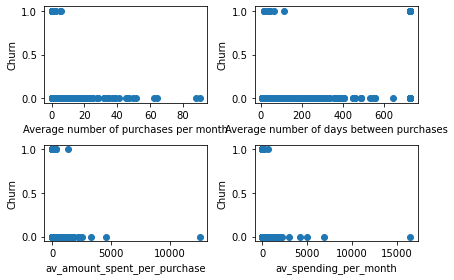

In [160]:
#so as we start with our logistic regression we have the following:
#dependent variable = Churn_binary

#independent variable =
# -av_num_purch_month 
# -Av_num_days_between_purchases
# -av_amount_spent_per_purchase
# -av_spending_per_month

lr_model1 = LogisticRegression()
lr_model2 = LogisticRegression()
lr_model3 = LogisticRegression()
lr_model4 = LogisticRegression()


lr_model1.fit(df_churner4[["av_num_purch_month"]], df_churner4["Churn_binary"])
lr_model2.fit(df_churner4[["Av_num_days_between_purchases"]], df_churner4["Churn_binary"])
lr_model3.fit(df_churner4[["av_amount_spent_per_purchase"]], df_churner4["Churn_binary"])
lr_model4.fit(df_churner4[["av_spending_per_month"]], df_churner4["Churn_binary"])

churn_est1 = lr_model1.predict(df_churner4[["av_num_purch_month"]])
churn_est2 = lr_model1.predict(df_churner4[["Av_num_days_between_purchases"]])
churn_est3 = lr_model1.predict(df_churner4[["av_amount_spent_per_purchase"]])
churn_est4 = lr_model1.predict(df_churner4[["av_spending_per_month"]])


plt.subplot(2,2,1)
plt.scatter(df_churner4["av_num_purch_month"], df_churner4["Churn_binary"])
plt.xlabel("Average number of purchases per month")
plt.ylabel("Churn")

plt.subplot(2,2,2)
plt.scatter(df_churner4["Av_num_days_between_purchases"], df_churner4["Churn_binary"])
plt.xlabel("Average number of days between purchases")
plt.ylabel("Churn")

plt.subplot(2,2,3)
plt.scatter(df_churner4["av_amount_spent_per_purchase"], df_churner4["Churn_binary"])
plt.xlabel("av_amount_spent_per_purchase")
plt.ylabel("Churn")


plt.subplot(2,2,4)
plt.scatter(df_churner4["av_spending_per_month"][df_churner4["av_spending_per_month"] < 20000], df_churner4["Churn_binary"][df_churner4["av_spending_per_month"] < 20000])
plt.xlabel("av_spending_per_month")
plt.ylabel("Churn")

plt.tight_layout()


#Our predictions for these variables are not really that significant so maybe some other variables should be looked at,
#maybe our churn should change?

In [ ]:
#the confusion matrix is rather useless because we 'predict' that almost every customer won't churn according to our definition
#sklearn.metrics.confusion_matrix(df_churner4["Churn_binary"] , churn_est1)
#sklearn.metrics.confusion_matrix(df_churner4["Churn_binary"] , churn_est2)
#sklearn.metrics.confusion_matrix(df_churner4["Churn_binary"] , churn_est3)
#sklearn.metrics.confusion_matrix(df_churner4["Churn_binary"] , churn_est4)

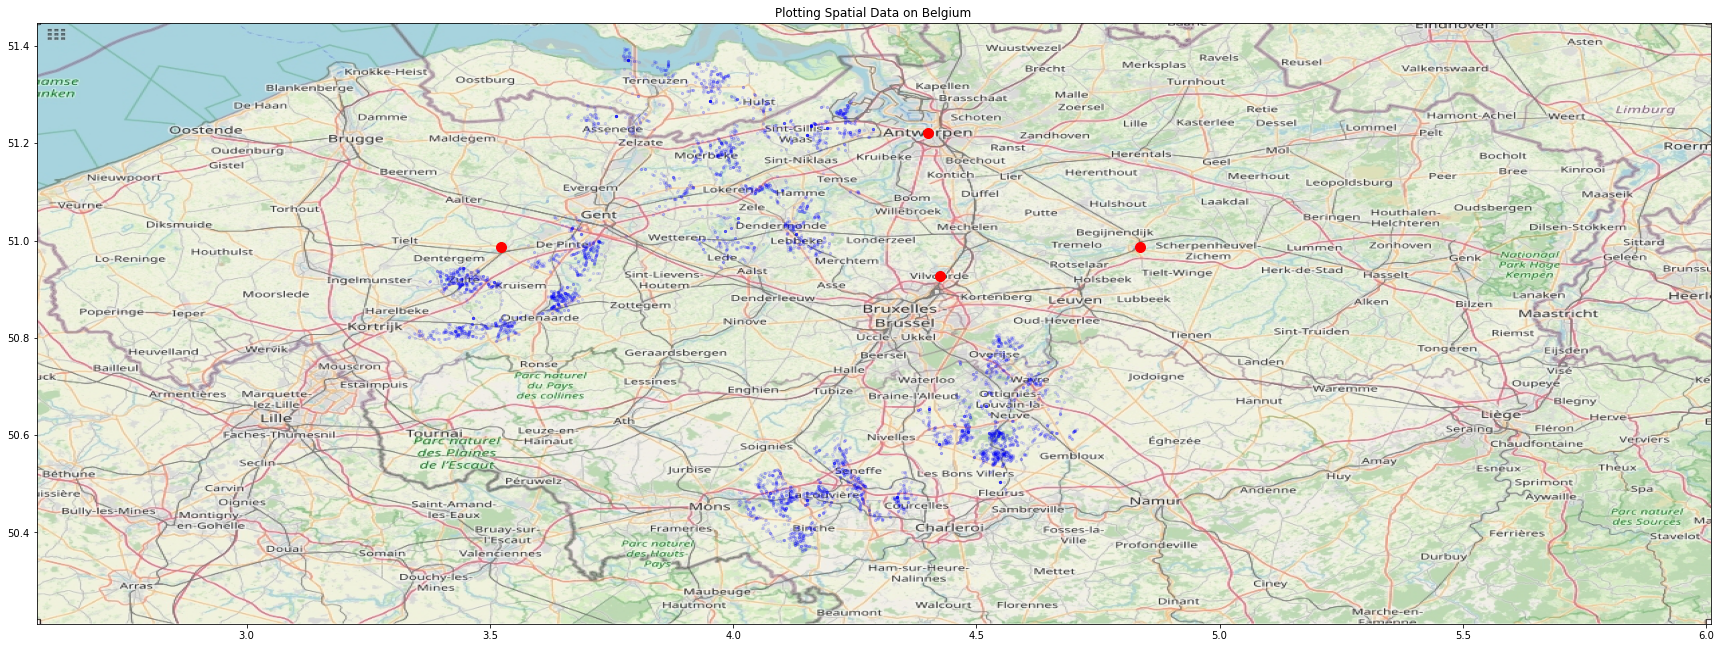

In [46]:
#Q2.5 Are there clusters of customers? How would you describe these different clusters?
###########################################################################################################################
#IMPORTANT To run this however you need to run Q2.7 first!!! We need CLV column from Customertype and this is added in Q2.7
# IMPORTANT !!!!!!!!!!!!!!!!!!!! 
######################################################################################################################


#Q2.5 Are there clusters of customers? How would you describe these different clusters?

#let's start by looking at the maximum range of the coordinates, we create a Bounding Box
BBox = ((df_Position["LONG"].min(), df_Position["LONG"].max(), df_Position["LAT"].min(), df_Position["LAT"].max()))
#the min and max LONG and LAT are respectively: (3.334474113603079, 4.707188589012247, 49.62586258530627, 51.39655183995949)

#Next we load a screenshot of belgium, this screenshot was taken on the website: 
#https://www.openstreetmap.org/export#map=9/50.8181/4.3698
#with the borders set on (2.5681,6.0095,50.2121,51.4472). 
#These borders are larger than the BBox values but that's because this results in a more clear picture

directory = "C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/ma.jpg"       #SET DIRECTORY VOOR WAAR UW LEGE MAP OPGESLAGEN IS
afb = plt.imread(directory) #download the map and change directory


#finally start plotting al the coordinates in blue, and the depot coordinates.
#for coordinates from the depot I just took the coordinates from the city it is located on (searched on google)
fig, ax = plt.subplots(figsize = (30,60))
ax.scatter(df_Position.LONG, df_Position.LAT, zorder=1, alpha= 0.1, c='b', s=5) #plotten van de coordinaten op de kaart
ax.set_title('Plotting Spatial Data on Belgium')
ax.set_xlim(2.5681,6.0095)
ax.set_ylim(50.2121,51.4472)
ax.scatter([3.5235857, 4.3997081, 4.8365218, 4.4257868],                    #coordinaten van respectievelijk DEINZE, ANTWERPEN, 
            [50.9875406, 51.2211097, 50.9859959, 50.9272511],               #Aarschot en Vilvoorde
           zorder = 1, c = 'r', s=100)   
ax.imshow(afb, zorder=0, extent = (2.5681,6.0095,50.2121,51.4472), aspect= 'equal')

In [51]:
#Q2.6 Do customers have different buying patterns during the weekend?

#This method uses the weekday function to determine the day of the week starting 
#At 0 for Monday and ending on 6 for Sunday for a given month and year
#In this way if the returned number is larger than 4 (Friday) it is a weekendDay
def getWeekIndex(d: datetime.date):
    if(d.weekday()>4):
        return "weekend"
    else:
        return "weekday"

#We add a new Column explaining wheter it is a weekday or weekend based on the calculated Date index
df_CompanyVisit["DateIndex"] = df_CompanyVisit["Date"].apply(getWeekIndex)
#We put the keys of CompanyVisit in a extra column named "VISIT_ID"
df_CompanyVisit["Visit_ID"] = df_CompanyVisit.index
#We can merge visitdetails on visits based on the same named column visit_ID created earlier
CompleteMerge = pd.merge(df_VisitDetails, df_CompanyVisit, on="Visit_ID")

#We also get the keys of products in a new Column
df_Products["Product_ID"] = df_Products.index
#We merge our earlier dataframe with the products so we can also get the product info from each visit to later sort on
#we also drop non relevant columns
CompleteMergeProd = pd.merge(CompleteMerge,df_Products, on="Product_ID").drop(columns=["paymentMethod", "Amount", "Time"])
#We recalculate the Revenue by taking the quantity * price for each visit and getting the revenue 
CompleteMergeProd["Revenue"]=CompleteMergeProd["Quantity"]*CompleteMergeProd["Price"]

#We now seperate the dataframe in 2: One has the visits and revenue from weekdays only
#While the other has only the information from visits on weekends
OnlyWeekdays= CompleteMergeProd[CompleteMergeProd["DateIndex"] != "weekend"]
OnlyWeekends= CompleteMergeProd[CompleteMergeProd["DateIndex"] != "weekday"]

#We can now analyse the overal revenue by customers ordered
# We devide by 5 for weekdays and 2 for weekends to rescale to a weekday or weekendday 
OnlyWeekdaysCus = OnlyWeekdays.groupby(["Customer_ID","DateIndex"])["Revenue"].sum()/5
OnlyWeekendsCus = OnlyWeekends.groupby(["Customer_ID","DateIndex"])["Revenue"].sum()/2

#We compare these sales with eachother in the following dataframe
Comparison = pd.merge(OnlyWeekendsCus,OnlyWeekdaysCus, on="Customer_ID")

#X is weekends Y is weekdays
#This shows the difference in Revenue expressed in mean and other statistics
#Comparing the weekend and weekdays
#print(Comparison.describe())

#We go onestep further and have a look at the difference in products sold between weekend and weekday
OnlyWeekdaysPro =  OnlyWeekdays.groupby(["Product_ID","DateIndex"])["Revenue"].sum()/5
OnlyWeekendsPro =  OnlyWeekends.groupby(["Product_ID","DateIndex"])["Revenue"].sum()/2


#We merge these with df_products to get info on family category and description of all products bought
#during visits
OnlyWeekdaysProMerged = pd.merge(OnlyWeekdaysPro,df_Products, on="Product_ID").drop(columns="Price")
OnlyWeekendsProMerged =  pd.merge(OnlyWeekendsPro,df_Products, on="Product_ID").drop(columns="Price")

#Firstly we look at the family of the product
OnlyWeekdaysProMergedFam =  pd.merge(OnlyWeekdaysPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Family")["Revenue"].sum()/5
OnlyWeekendsProMergedFam =  pd.merge(OnlyWeekendsPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Family")["Revenue"].sum()/2


OnlyWeekdaysProMergedFamAbs =  pd.merge(OnlyWeekdaysPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Family")["Revenue"].sum()
OnlyWeekendsProMergedFamAbs =  pd.merge(OnlyWeekendsPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Family")["Revenue"].sum()

OnlyWeekdaysProMergedFam=(OnlyWeekdaysProMergedFam/OnlyWeekdaysProMergedFam.values.sum())*100
OnlyWeekendsProMergedFam=(OnlyWeekendsProMergedFam/OnlyWeekendsProMergedFam.values.sum())*100

#X is weekends Y is weekdays
#This show what Family sells more during either weekend or weekday
WeekendComparedFam = pd.merge(OnlyWeekendsProMergedFam,OnlyWeekdaysProMergedFam, on="Family")
print(WeekendComparedFam)

#We do the same process for decription
OnlyWeekdaysProMergedDes =  pd.merge(OnlyWeekdaysPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Description")["Revenue"].sum()/5
OnlyWeekendsProMergedDes =  pd.merge(OnlyWeekendsPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Description")["Revenue"].sum()/2

OnlyWeekdaysProMergedDes=(OnlyWeekdaysProMergedDes/OnlyWeekdaysProMergedDes.values.sum())*100
OnlyWeekendsProMergedDes=(OnlyWeekendsProMergedDes/OnlyWeekendsProMergedDes.values.sum())*100

#X is weekends Y is weekdays
#This show which products sell more during either weekend or weekday
WeekendComparedDis= pd.merge(OnlyWeekendsProMergedDes,OnlyWeekdaysProMergedDes, on="Description")
print(WeekendComparedDis)

#We do the same process for Category
OnlyWeekdaysProMergedCat =  pd.merge(OnlyWeekdaysPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Category")["Revenue"].sum()/5
OnlyWeekendsProMergedCat =  pd.merge(OnlyWeekendsPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Category")["Revenue"].sum()/2

OnlyWeekdaysProMergedCat=(OnlyWeekdaysProMergedCat/OnlyWeekdaysProMergedCat.values.sum())*100
OnlyWeekendsProMergedCat=(OnlyWeekendsProMergedCat/OnlyWeekendsProMergedCat.values.sum())*100
#X is weekends Y is weekdays
#This show which product Catogoryy sell more during either weekend or weekday
WeekendComparedCat= pd.merge(OnlyWeekendsProMergedCat,OnlyWeekdaysProMergedCat, on="Category")
print(WeekendComparedCat)


#we print this to compare complete sales: you sell more over saturday and sunday
#than all other weekdays combined
print(OnlyWeekdaysProMergedFamAbs.values.sum()) #138 752.38 over all weekdays
print(OnlyWeekendsProMergedFamAbs.values.sum()) #185 343.95 over the whole weekend


                    Revenue_x  Revenue_y
Family                                  
Assortments          5.899114   5.656206
BIG                  1.020373   0.930809
Coffee               3.020951   2.960728
Coupon               0.015188   0.338358
Cups                 8.928778  11.176284
Garniture            1.809015   0.936532
Hand Ice            37.381824  37.544913
Ice Cakes            6.373502   5.656566
Individual Dessert   5.189271   5.035762
Meals                4.075612   3.454759
POS inside           0.065014   0.067329
Scoop Ice           26.221358  26.241755
                            Revenue_x  Revenue_y
Description                                     
1 L.Aardbei                  0.176672   0.242663
1 L.Amarena                  0.001942   0.003632
1 L.Banaan                   0.094837   0.125828
1 L.Chocolade                0.336375   0.355727
1 L.Citroen                  0.159703   0.121065
...                               ...        ...
Waaiers Horeca/220           0.070

In [55]:
#Q2.7 Do customer sales differ across different cities? Is there a relationship between customer
#sales and average income per inhabitant (and other factors)?
##Important!!! running this question requires running question 2.3 for the CLV dataframe

##This question might require a rerun of the reading in data and putting it into dataframes
df_CustomerType["CLV"]=df_CLV
df_CustomerType = df_CustomerType.dropna(axis="rows")
#df_RouteTemplate["RouteTemplate_ID"]=df_RouteTemplate.index


#This compares CLV over all regions merging over Routetempate to get CLV linked to The Region
df_CLV_Route = pd.merge(df_CustomerType,df_RouteTemplate, on="RouteTemplate_ID")
df_CLV_Route_Region = df_CLV_Route.groupby("REGION")["CLV"].sum()
print(df_CLV_Route_Region)

#Compares CLV over all Cities
#We change the name of the column to be able to merge on the same name
#print(df_Depot.drop(columns="RouteTemplate_ID"))
#df_Depot=df_Depot.rename(columns={"HVROUTETEMPLATE_NRID": "RouteTemplate_ID"})
df_CLV_Cities= pd.merge(df_CLV_Route,df_Depot,on="RouteTemplate_ID").groupby("DEPOT")["CLV"].sum()
print(df_CLV_Cities.head(10))

#Now we introduce a lin reg
lr_model = LinearRegression()
#We merge customertype with the new CSV income per postcode to get median income and average income
#Based on where the customer lives
df_featuresFrame = pd.merge(df_CustomerType,df_Income_per_postcode, how="right" ,on="Postcode")
df_featuresFrame=df_featuresFrame.dropna()

#We apply scalers to these paramaters (Also cat var??)
scaler = StandardScaler(df_featuresFrame)
df_featuresFrame["AVERAGE_INCOME"] = df_featuresFrame["AVERAGE_INCOME"].astype(float)
df_featuresFrame["MEDIAN_INCOME"] = df_featuresFrame["MEDIAN_INCOME"].astype(float)

#now we label catogory variables
label_encoder1 = LabelEncoder()
label_encoder1.fit(df_featuresFrame["CustomerType"])
def changeLan(lang):
    if(lang == "nl_BE"):
        return 0
    else:
        return 1    

#This assigns 0,1,2 (Catering, Private, Horeca)
df_featuresFrame["CustomerTypeNum"] = label_encoder1.transform(df_featuresFrame["CustomerType"])    

#0 is dutch 1 speaks french after applying the function
df_featuresFrame["Language"]=df_featuresFrame["Language"].apply(changeLan)
print(df_featuresFrame.head(5))

#Scale the features
scaler.fit(df_featuresFrame[["AVERAGE_INCOME","MEDIAN_INCOME","CustomerTypeNum","Language"]])


#I have no idea how to incorprate CUSTOMERTYPENUM and LANGUAGE because they are catogorical vars so idk if this is right
lr_model.fit(X=df_featuresFrame[["AVERAGE_INCOME","MEDIAN_INCOME","CustomerTypeNum","Language"]], y=df_featuresFrame["CLV"])
lr_model.coef_



REGION
B02    290525.55
B25    318953.00
C04    226554.05
C17    228417.20
Name: CLV, dtype: float64
DEPOT
Aarschot      92116.55
Antwerpen    286587.15
Deinze       259064.85
Vilvoorde    449843.50
Name: CLV, dtype: float64
   RouteTemplate_ID CustomerType  Postcode  Language    Season  Customer_ID  \
0       289662608.0      Private      3500         1  All time     871717.0   
1       289662608.0      Private      3500         1  All time     872247.0   
2       289658600.0      Private      3500         1  All time    1403388.0   
3       289658600.0      Private      3500         1  All time    1403426.0   
4       289658600.0      Private      3500         1  All time    1403432.0   

     CLV City_name  AVERAGE_INCOME  MEDIAN_INCOME  CustomerTypeNum  
0  285.2   Hasselt         35091.0        26519.0                2  
1  103.2   Hasselt         35091.0        26519.0                2  
2  117.0   Hasselt         35091.0        26519.0                2  
3   82.6   Hasselt      

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass copy=      RouteTemplate_ID CustomerType  Postcode Language    Season  \
0          289662608.0      Private      3500    nl-BE  All time   
1          289662608.0      Private      3500    nl-BE  All time   
2          289658600.0      Private      3500    nl-BE  All time   
3          289658600.0      Private      3500    nl-BE  All time   
4          289658600.0      Private      3500    nl-BE  All time   
...                ...          ...       ...      ...       ...   
5273       289757472.0      Private      3960    nl-BE  All time   
5274       289757472.0      Private      3960    nl-BE  All time   
5275       289757472.0      Private      3960    nl-BE  All time   
5276       289757472.0      Private      3960    nl-BE  All time   
5277       289757472.0      Private      3960    nl-BE  All time   

       Customer_ID      CLV City_name  AVERAGE_INCOME  MEDIAN_INCOME  
0     8.717170e

array([-4.13136511e-03,  1.25398350e-02, -7.72384949e+02,  0.00000000e+00])

In [ ]:
##########################
#Q3 Who are the employees?
##########################

In [97]:
#Q3.1 What are the routes of the employees?
# First we merge df_CompanyVisit and df_CustomerType on the key Customer_ID
df_CustomerType2 = df_CustomerType
df_CustomerType2['Customer_ID'] = df_CustomerType.index

df_routesWithEmployees = pd.merge(df_CompanyVisit, df_CustomerType2, how = "inner", on = "Customer_ID")

df_routesWithEmployees = df_routesWithEmployees[['Employee_ID', 'RouteTemplate_ID']].drop_duplicates()

df_routesWithEmployees = df_routesWithEmployees.sort_values(by = ['Employee_ID'])

# print(df_routesWithEmployees.head())
# print(len(df_routesWithEmployees))

In [ ]:
### M'n eigen gepruts die ik mss nog kan gebruiken dus nog niet direct verwijderen!
# # Because the column name for Customer ID of df_Position doesn't correspond to the column name 'Customer_ID', we create a duplicate of df_Position, but now with the same column name
# df_Position2 = df_Position
# df_Position2 = df_Position2.rename(columns = {'CustomerID': 'Customer_ID'})
# # We merge the dataframe we've created with this new df_Position based on the key Customer_ID
# df_routesWithEmployees_withPositions = pd.merge(df_routesWithEmployees, df_Position2, how = "inner", on = "Customer_ID")
# print(df_routesWithEmployees_withPositions.head())



# df_CompanyEmployees2 = df_CompanyEmployees
# df_CompanyEmployees2['Employee_ID'] = df_CompanyEmployees.index
# df_employee_visit_results = df_CompanyEmployees2.merge(df_CompanyVisit, how="inner", on = 'Employee_ID')

# df_RouteTemplate2 = df_RouteTemplate
# df_RouteTemplate2['RouteTemplate_ID'] = df_RouteTemplate.index
# df_CustomerType2 = df_CustomerType
# df_CustomerType2['Customer_ID'] = df_CustomerType.index
# df_customer_route_templates = df_CustomerType2.merge(df_RouteTemplate2, how = "inner", on = 'RouteTemplate_ID')

# df_customer_employee_visit_results = df_employee_visit_results.merge(df_customer_route_templates, how="inner", on = "Customer_ID")

# df_Position2 = df_Position
# df_Position2['Customer_ID'] = df_Position2.index

# df_customer_employee_visit_results = df_customer_employee_visit_results.merge(df_Position2, how = "left", on = "Customer_ID")
# df_customer_employee_visit_results.head()

# # Unique employee routes
# df_employee_routes = df_customer_employee_visit_results[['Employee_ID', 'RouteTemplate_ID', 'LAT', 'LONG']].drop_duplicates()
# df_employee_routes = df_employee_routes.sort_values(by = ["Employee_ID"])
# print(len(df_employee_routes))
# print(df_employee_routes.head())
# df_employee_routes = df_employee_routes.merge(df_RouteTemplate2, how = "inner", on = "RouteTemplate_ID")
# print(df_employee_routes.head())

#Plotting the different routes and the accompanying employees

In [ ]:
#Q3.2 What is the turnover for each employee?
#Total
df_CompanyEmployees2 = df_CompanyEmployees
df_CompanyEmployees2['Employee_ID'] = df_CompanyEmployees.index
df_employeeVisitResults = df_CompanyEmployees2.merge(df_CompanyVisit, how="inner", on = 'Employee_ID')

salesHappened = df_employeeVisitResults[df_employeeVisitResults['VisitOutcome_ID']==2]
salesHappened["Date"] = pd.to_datetime(salesHappened["Date"])

salesPerEmployee = salesHappened.groupby(['Employee_ID','Name'], as_index= False)['Amount'].sum()
salesPerEmployee = salesPerEmployee.sort_values(by = "Amount", ascending=False)

# print(len(salesPerEmployee))
# print(salesPerEmployee.head())

#For 2020
salesHappened2020 = salesHappened[salesHappened['Date'].dt.year == 2020]
salesPerEmployee2020 = salesHappened2020.groupby(['Employee_ID','Name'], as_index= False)['Amount'].sum()
salesPerEmployee2020 = salesPerEmployee2020.sort_values(by = "Amount", ascending=False)

# print(len(salesPerEmployee2020))
# print(salesPerEmployee2020.head())

In [163]:
########################
#Q4 What are the routes?
########################
#Let's start by merging the df_RouteTemplate datdabse with the other two databases (CustomerType and Depotfor closer detail
#The merge is done via the equally named column "HVROUTETEMPLATE_NRID" in all databases.
#However the df_RouteTemplate contains these ID's in the first column, was this was the list of keys from our dictionary
#This results in the first column having no columname to merge with other databases. To solve this we can copy this column.
#After we copied this column we can add it to our original database, we now have duplicate column with which we can work with.
df_RouteTemplate["RouteTemplate_ID"] = df_RouteTemplate.index

#next we will merge the two databases df_RouteTemplate and df_CustomerType in order to link our customer and route info
df_CustomerType["CustomerID"]=df_CustomerType.index
df_Customer_Route = pd.merge(df_CustomerType, df_RouteTemplate, how = "left", on = "RouteTemplate_ID")
#for future question we will also need the depot so that's why we join them as well
df_Customer_Route_Depot = pd.merge(df_Depot, df_Customer_Route, how = "left", on = "RouteTemplate_ID")
df_CustomerType.head(5)
#df_Customer_Route.head(5)
#increasing the view of our dataframe, set the parameters if you want less rows to be visible
# pd.set_option("display.max_rows", None, "display.max_columns", None)

RouteTemplate_ID CustomerType  Postcode Language    Season  \
721110         219020601      Private      3930    nl-BE  All time   
721121         219020601      Private      3930    nl-BE  All time   
721126         219020601      Private      3930    nl-BE  All time   
721131         219020601      Private      3930    nl-BE  All time   
721136         219020601      Private      3930    nl-BE  All time   

        Customer_ID    CLV  CustomerID  
721110       721110  183.6      721110  
721121       721121   74.7      721121  
721126       721126  121.3      721126  
721131       721131  468.9      721131  
721136       721136  104.6      721136

In [164]:
#Q4.1 How are the customers divided into regions?
#here we can see that every customer has its own routenumber, postcode, region, weekorder and dayofweek. 
#If we make a subselection of our total database and remove all duplicates for our region and postcode,
#we can find a database that shows us each region linked to each unique postcode, as we assumed (see picture of map)
#all unique postcodes are clustered in 4 groups en each cluster of postcodes corresponds to the same region!
#so to answer: The postcode of a customer determines its REGION
df_Customer_Route_Depot.drop_duplicates(subset = ["Postcode", "REGION"]).sort_values(by="REGION")

DEPOT  HVROUTETEMPLATE_NRID  RouteTemplate_ID CustomerType  \
3118  Vilvoorde             289419955         289419955      Private   
1204     Deinze             289414945         289414945      Private   
2809  Vilvoorde             289416949         289416949      Private   
1633  Antwerpen             289756470         289756470      Private   
3060  Vilvoorde             289761480         289761480      Private   
1329     Deinze             289757472         289757472      Private   
1334     Deinze             289757472         289757472      Private   
1390     Deinze             289757472         289757472      Private   
1623  Antwerpen             289756470         289756470      Private   
2086  Antwerpen             289763484         289763484      Private   
0        Deinze             219020601         219020601      Private   
1510  Antwerpen             219018687         219018687      Private   
256      Deinze             219024456         219024456      Private   
9        Deinze             219020601         219020601      Private   
3881  Vilvoorde             289661606         289661606      Private   
4149  Vilvoorde             289655594         289655594      Private   
4220  Vilvoorde             289655594         289655594      Private   
4346  Vilvoorde             289659602         289659602      Private   
5268   Aarschot             289657598         289657598      Private   

      Postcode Language    Season  Customer_ID     CLV  CustomerID REGION  \
3118      3550    nl-BE  All time      1249654  165.25     1249654    B02   
1204      3582    nl-BE  All time      1245116  140.85     1245116    B02   
2809      3580    nl-BE  All time       687782  182.00      687782    B02   
1633      3670    nl-BE  All time       878365  117.10      878365    B25   
3060      3668    nl-BE  All time       870198  241.30      870198    B25   
1329      3640    nl-BE  All time      1451889   52.35     1451889    B25   
1334      3960    nl-BE  All time     56963283  222.40    56963283    B25   
1390      3680    nl-BE  All time     56366188    0.00    56366188    B25   
1623      3660    nl-BE  All time       876603  419.10      876603    B25   
2086      3650    nl-BE  All time       877993   42.80      877993    B25   
0         3930    nl-BE  All time       721110  183.60      721110    C04   
1510      3960    nl-BE  All time       718512  327.00      718512    C04   
256       3950    nl-BE  All time       724562  460.10      724562    C04   
9         3910    nl-BE  All time       720545   58.70      720545    C04   
3881      3590    nl-BE  All time       880478  115.80      880478    C17   
4149      3500    nl-BE  All time      1403507  130.60     1403507    C17   
4220      3511    nl-BE  All time      1394755  133.10     1394755    C17   
4346      3600    nl-BE  All time      1398075  240.00     1398075    C17   
5268      3501    nl-BE  All time      1403618  481.65     1403618    C17   

     WEEKORDER DAYOFWEEK_NRID  
3118       2.0            6.0  
1204       1.0            6.0  
2809       2.0            3.0  
1633       1.0            3.0  
3060       2.0            3.0  
1329       1.0            4.0  
1334       1.0            4.0  
1390       1.0            4.0  
1623       1.0            3.0  
2086       2.0            5.0  
0          1.0            5.0  
1510       1.0            2.0  
256        2.0            6.0  
9          1.0            5.0  
3881       2.0            3.0  
4149       1.0            2.0  
4220       1.0            2.0  
4346       1.0            6.0  
5268       1.0            4.0

In [165]:
#Q4.2 Which customers are assigned to which routes?
df_Customer_Route_Depot.drop_duplicates(subset = ["RouteTemplate_ID", "WEEKORDER", "DAYOFWEEK_NRID"]).sort_values(by=["RouteTemplate_ID", "WEEKORDER", "DAYOFWEEK_NRID"])
df_Customer_Route_Depot.drop_duplicates().sort_values(by=["RouteTemplate_ID", "WEEKORDER", "DAYOFWEEK_NRID"])
df_CRV = pd.merge(df_CustomerType, df_Customer_Route_Depot, on="RouteTemplate_ID").drop(columns=["Postcode_x","CustomerID_x","CustomerType_x","Language_x","Season_x"])
df_CRV.sort_values(by=["CustomerID_y"])
df_CRV.head(5)

RouteTemplate_ID  Customer_ID_x  CLV_x   DEPOT  HVROUTETEMPLATE_NRID  \
0         219020601         721110  183.6  Deinze             219020601   
1         219020601         721110  183.6  Deinze             219020601   
2         219020601         721110  183.6  Deinze             219020601   
3         219020601         721110  183.6  Deinze             219020601   
4         219020601         721110  183.6  Deinze             219020601   

  CustomerType_y  Postcode_y Language_y  Season_y  Customer_ID_y  CLV_y  \
0        Private        3930      nl-BE  All time         721110  183.6   
1        Private        3930      nl-BE  All time         721121   74.7   
2        Private        3930      nl-BE  All time         721126  121.3   
3        Private        3930      nl-BE  All time         721131  468.9   
4        Private        3930      nl-BE  All time         721136  104.6   

   CustomerID_y REGION WEEKORDER DAYOFWEEK_NRID  
0        721110    C04       1.0            5.0  
1        721121    C04       1.0            5.0  
2        721126    C04       1.0            5.0  
3        721131    C04       1.0            5.0  
4        721136    C04       1.0            5.0

In [166]:
#Q4.3 Which routes are assigned to which depots?
#In the dataframe below we can see for each depot every single possible route, the total number of routes in the dataframe is
#39 which corresponds to the df_RouteTemplate dataframe, where there were 39 possible routes
#This shows that every route is linked to a certain depot
df_Customer_Route_Depot.drop_duplicates(subset = ["DEPOT", "RouteTemplate_ID"]).sort_values(by = "DEPOT")
#len(df_Customer_Route_Depot.drop_duplicates(subset = ["DEPOT", "RouteTemplate_ID"]).sort_values(by = "DEPOT").index)

DEPOT  HVROUTETEMPLATE_NRID  RouteTemplate_ID CustomerType  \
5266   Aarschot             289657598         289657598      Private   
4979   Aarschot             289662608         289662608      Private   
4888   Aarschot             289663610         289663610       Horeca   
5131   Aarschot             289658600         289658600      Private   
2660  Antwerpen             289760478         289760478      Private   
2383  Antwerpen             289762482         289762482      Private   
2227  Antwerpen             289758474         289758474      Private   
2086  Antwerpen             289763484         289763484      Private   
1960  Antwerpen             289759476         289759476      Private   
1790  Antwerpen             289755468         289755468      Private   
1623  Antwerpen             289756470         289756470      Private   
1481  Antwerpen             219018687         219018687      Private   
2528  Antwerpen             289764486         289764486      Private   
1329     Deinze             289757472         289757472      Private   
129      Deinze             219021241         219021241      Private   
255      Deinze             219024456         219024456       Horeca   
1480     Deinze              70671404          70671404     Catering   
374      Deinze             219021882         219021882      Private   
485      Deinze             219022524         219022524      Private   
0        Deinze             219020601         219020601      Private   
741      Deinze             219023811         219023811      Private   
1204     Deinze             289414945         289414945      Private   
1022     Deinze             219019962         219019962      Private   
864      Deinze             219019324         219019324      Private   
596      Deinze             219023167         219023167      Private   
4772  Vilvoorde             289664612         289664612      Private   
4536  Vilvoorde             289656596         289656596      Private   
4419  Vilvoorde             289660604         289660604      Private   
4301  Vilvoorde             289659602         289659602      Private   
4149  Vilvoorde             289655594         289655594      Private   
4022  Vilvoorde             289413943         289413943      Private   
3727  Vilvoorde             289412941         289412941      Private   
3579  Vilvoorde             289411939         289411939      Private   
3229  Vilvoorde             289417951         289417951      Private   
3118  Vilvoorde             289419955         289419955      Private   
2958  Vilvoorde             289761480         289761480      Private   
2809  Vilvoorde             289416949         289416949      Private   
3881  Vilvoorde             289661606         289661606      Private   
3407  Vilvoorde             289418953         289418953      Private   

      Postcode Language    Season     Customer_ID       CLV      CustomerID  \
5266      3500    nl-BE  All time         1403584    198.20         1403584   
4979      3500    nl-BE  All time          871717    285.20          871717   
4888      3500    nl-BE  All time         1403452   3056.15         1403452   
5131      3500    nl-BE  All time         1403388    117.00         1403388   
2660      3680    nl-BE  All time         1450605    337.60         1450605   
2383      3680    nl-BE  All time          879566    181.90          879566   
2227      3650    nl-BE  All time          878045    182.80          878045   
2086      3650    nl-BE  All time          877993     42.80          877993   
1960      3680    nl-BE  All time          877412    272.80          877412   
1790      3680    nl-BE  All time          877215    168.60          877215   
1623      3660    nl-BE  All time          876603    419.10          876603   
1481      3950    nl-BE  All time          718230    236.20          718230   
2528      3680    nl-BE  All time          871129     87.00          871129   
1329      3640    nl-BE

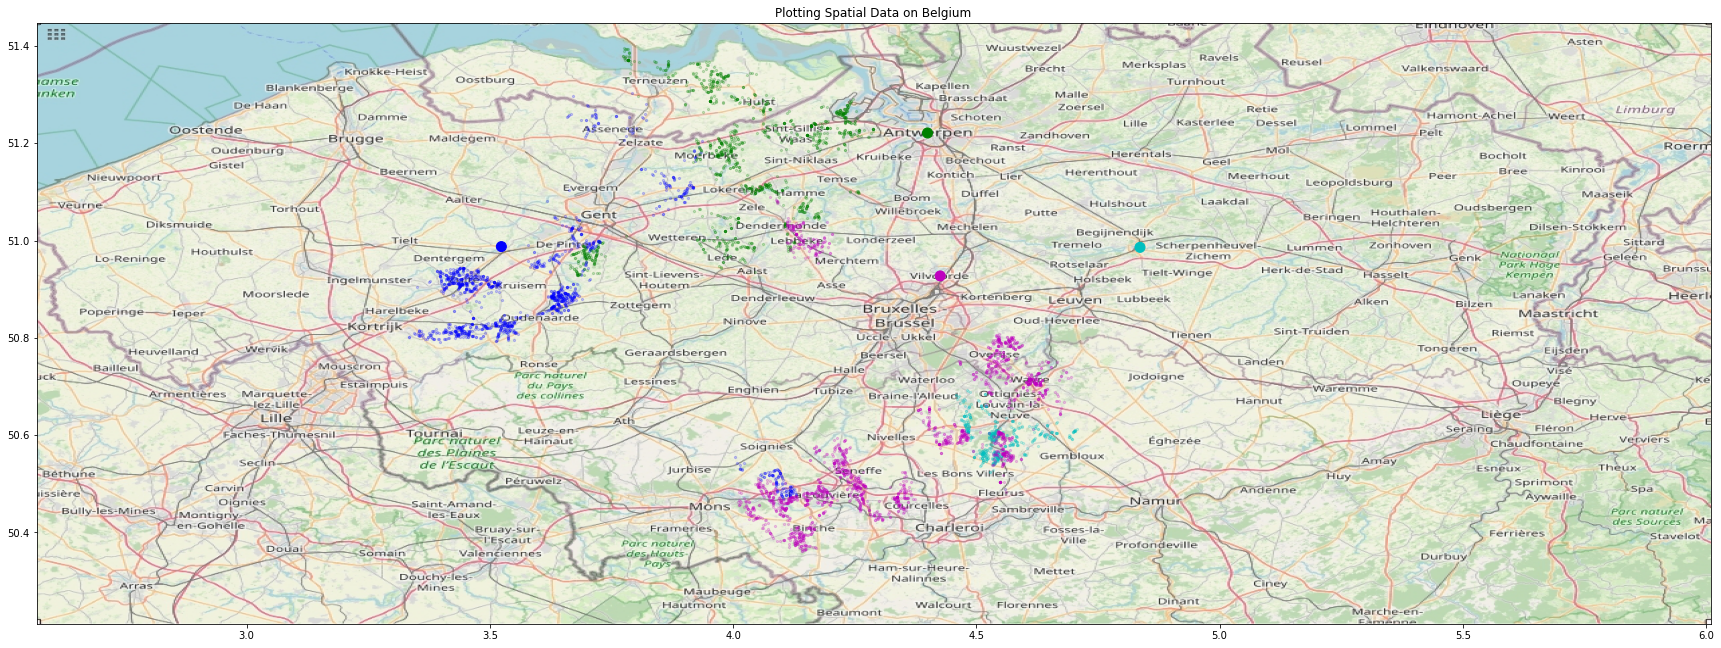

In [167]:
#Lets plot the customers again this time, however now we are going to colour match all the customers based on which depot
#makes their deliveries!

#initialize the dataframe and merge it with the customer rout depot from Q4 in order to link customer ID and the city of the depot
df_Position["CustomerID"] = df_Position.index

df_customer_locations = pd.merge(df_Customer_Route_Depot,df_Position, how = "left", on = "CustomerID").drop(
    columns = ["RouteTemplate_ID", "Postcode", "Language", "Season", "WEEKORDER", "DAYOFWEEK_NRID"])

#we now create 4 seperate datafrmes which each contain all the coordinates of the people that get deliverd by this depot
df_deinze = df_customer_locations[df_customer_locations["DEPOT"].str.contains("Deinze")]
df_antwerpen = df_customer_locations[df_customer_locations["DEPOT"].str.contains("Antwerpen")]
df_aarschot = df_customer_locations[df_customer_locations["DEPOT"].str.contains("Aarschot")]
df_vilvoorde = df_customer_locations[df_customer_locations["DEPOT"].str.contains("Vilvoorde")]

#We plot all coordinates based on a colorschema
fig, ax = plt.subplots(figsize = (30,50))
ax.scatter(df_deinze.LONG, df_deinze.LAT, zorder=1, alpha= 0.2, c='b', s=5)  #deinze is blauw
ax.scatter(df_antwerpen.LONG, df_antwerpen.LAT, zorder=1, alpha= 0.2, c='g', s=5)   #antwerpen groen
ax.scatter(df_aarschot.LONG, df_aarschot.LAT, zorder=1, alpha= 0.2, c='c', s=5)   #aarschot cyan
ax.scatter(df_vilvoorde.LONG, df_vilvoorde.LAT, zorder=1, alpha= 0.2, c='m', s=5)  #vilvoorde roze

ax.set_title('Plotting Spatial Data on Belgium')
ax.set_xlim(2.5681,6.0095)
ax.set_ylim(50.2121,51.4472)
ax.scatter([3.5235857, 4.3997081, 4.8365218, 4.4257868],                    #coordinaten van respectievelijk DEINZE, ANTWERPEN, 
            [50.9875406, 51.2211097, 50.9859959, 50.9272511],               #Aarschot en Vilvoorde
           zorder = 1, c = ["b", "g", "c", "m"], s=100)   
ax.imshow(afb, zorder=0, extent = (2.5681,6.0095,50.2121,51.4472), aspect= 'equal')

In [ ]:
############################################
#Q5 How can the company improve its service?
############################################

Customer_ID
721228            14211.50
1451799            9938.90
20256376185452     8899.80
728498             8503.20
1250991            7041.70
1455143            6901.10
1247191            5640.80
727602             5391.30
18321288654234     5018.30
18416552167454     4218.95
1403452            3056.15
1246194            2681.70
1459877            2610.50
20682568164250     2442.80
1249611            1940.50
871033             1770.10
23984664674452     1729.30
1405104            1640.60
879714             1501.50
876592             1474.30
871291             1472.50
1398221            1453.35
19021184416246     1349.10
21916072234450     1337.80
23866844656650     1328.80
Name: Amount, dtype: float64


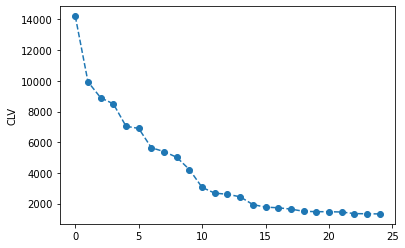

In [168]:
#Q5.1 Which customers should be rewarded?
#These would have to be the customers with the highest CLV: These have brought in the most
#Revenue for the firm over their lifetime
#In total we have 5709 customers

#Looking at the list we can find that the first customer on the list has an enormous
#14 211: so it is important to keep this customer
#There are also runner ups with 9938 and 8899
#The highest performing customers are the most important
#What is important to see is that between place 1 and 5 the CLV has already halved!
lyis = list()
lyis = df_CLV.head(25)
print(lyis)

lxis = list()
lxis = range(0,25)

plt.plot(lxis,lyis, linestyle='--', marker='o')
plt.ylabel('CLV')
plt.xlim()
plt.show()

#Looking at the graph we can see that the first customer clearly overperforms others
#Another insight can be that after the top 10 customers we arrive at an ellbow
#CLV starts to stagnate and in scale converges to zero
#So it is very important to focus on the first 10 best CLV performing Customers



In [169]:
#So these customers deserve rewards to surely keep them within the company
#We merge again with Customer Type to get the specific info on these customers

df_RewardFrame = pd.merge(df_CLV.head(10),df_CustomerType, how="left",on="Customer_ID").drop(columns=["Amount","RouteTemplate_ID","CustomerID"])
print(df_RewardFrame)

#If we take a look at these customers we find: 
#6 are Horeca and 4 are Catering customers: no private customers
#All speak Dutch

      Customer_ID CustomerType  Postcode Language    Season       CLV
0          721228       Horeca      3910    nl-BE  All time  14211.50
1         1451799       Horeca      3640    nl-BE  All time   9938.90
2  20256376185452     Catering      3550    nl-BE  All time   8899.80
3          728498       Horeca      3950    nl-BE  All time   8503.20
4         1250991       Horeca      3582    nl-BE  All time   7041.70
5         1455143       Horeca      3680    nl-BE  All time   6901.10
6         1247191     Catering      3582    nl-BE  All time   5640.80
7          727602     Catering      3930    nl-BE  All time   5391.30
8  18321288654234     Catering      3550    nl-BE  All time   5018.30
9  18416552167454       Horeca      3590    nl-BE  All time   4218.95


In [170]:
#If we have a look and calculate the CLV over all customers combined
#We can calculate the share in the total CLV these top 10 customers have
CompleteCLV = df_CLV.values.sum()
print("The complete CLV is:",CompleteCLV)
print()
df_RewardFrame["Share in CLV"]=(df_RewardFrame["CLV"]/CompleteCLV)*100
print(df_RewardFrame.drop(columns="Postcode"))

#Now we look at the share of all top 10 Customers in the total CLV
CLV_Top_10 = df_RewardFrame["Share in CLV"].sum()
print()
print("The top 10 customers share ",CLV_Top_10," percent in the total CLV")

#We can now see that keeping the top customers happy can be a good tactic 
#The top 10 customers jointly get 7.12 percent of the total CLV
#This is not a huge percentage but a nice insight

print(df_CustomerType)

The complete CLV is: 1064449.8

      Customer_ID CustomerType Language    Season       CLV  Share in CLV
0          721228       Horeca    nl-BE  All time  14211.50      1.335103
1         1451799       Horeca    nl-BE  All time   9938.90      0.933712
2  20256376185452     Catering    nl-BE  All time   8899.80      0.836094
3          728498       Horeca    nl-BE  All time   8503.20      0.798835
4         1250991       Horeca    nl-BE  All time   7041.70      0.661534
5         1455143       Horeca    nl-BE  All time   6901.10      0.648326
6         1247191     Catering    nl-BE  All time   5640.80      0.529926
7          727602     Catering    nl-BE  All time   5391.30      0.506487
8  18321288654234     Catering    nl-BE  All time   5018.30      0.471445
9  18416552167454       Horeca    nl-BE  All time   4218.95      0.396350

The top 10 customers share  7.1178133529641325  percent in the total CLV
                RouteTemplate_ID CustomerType  Postcode Language    Season  \
72

In [171]:
print(df_CustomerType.drop(columns=["Season","Postcode","Language","CustomerID","RouteTemplate_ID","CustomerID"]).sort_values(by="CLV",ascending=False).head(40))
#The highest Person in the list is on place 15: This is quite shocking  that a Private customer can land on place 15 followed by horeca and caterers
#Since these people are "smaller" than a caterer or horeca shops they are more subject to changes etc so keeping Private customer loyal remains very important
#Private customers bring in quite alot of CLV and the higest should receive special attention
#The plot made earlier showing the convergens indicates to focus on the biggest performing CLV customers from horeca and Catering
#But Private customers should be treated differntly and be rewarded more extensively
#So we would recommend rewarding the top 10 or 15 Horeca and Catering shops
#But the firm should reward more Private Customers
#Since it has been shown they have a good share in CLV and rewarding them is less expensive overall
#And keep them happy


               CustomerType     Customer_ID       CLV
721228               Horeca          721228  14211.50
1451799              Horeca         1451799   9938.90
20256376185452     Catering  20256376185452   8899.80
728498               Horeca          728498   8503.20
1250991              Horeca         1250991   7041.70
1455143              Horeca         1455143   6901.10
1247191            Catering         1247191   5640.80
727602             Catering          727602   5391.30
18321288654234     Catering  18321288654234   5018.30
18416552167454       Horeca  18416552167454   4218.95
1403452              Horeca         1403452   3056.15
1246194              Horeca         1246194   2681.70
1459877            Catering         1459877   2610.50
20682568164250     Catering  20682568164250   2442.80
1249611             Private         1249611   1940.50
871033              Private          871033   1770.10
23984664674452       Horeca  23984664674452   1729.30
1405104            Catering 

In [172]:
#Now we make a rewardframe: containing the people that should be rewarded
df_RewardFramePrivate = pd.merge(df_CLV,df_CustomerType, how="left",on="Customer_ID").drop(columns=["Amount","RouteTemplate_ID","CustomerID"]).sort_values(by="CLV",ascending=False)
df_RewardFramePrivate =  df_RewardFramePrivate[df_RewardFramePrivate["CustomerType"] == "Private"]

print(df_RewardFramePrivate.head(50))
#Based on the following result rewarding the first 50 Private customers would be adviced
#They are big spenders and should be kept 
#After the top 50 Private customers
#The value of CLV quickly diverges to 500 and lower 
#These customers are not recommended to reward since their share is not high enough in the CLV
#And many more customers are in this CLV range distribution 

       Customer_ID CustomerType  Postcode Language    Season      CLV
14         1249611      Private      3550    nl-BE  All time  1940.50
15          871033      Private      3650    nl-BE  All time  1770.10
19          876592      Private      3660    nl-BE  All time  1474.30
20          871291      Private      3650    nl-BE  All time  1472.50
21         1398221      Private      3590    nl-BE  All time  1453.35
29          871486      Private      3650    nl-BE  All time  1219.10
31  22112248445240      Private      3590    nl-BE  All time  1153.10
35         1395324      Private      3590    nl-BE  All time  1120.60
37          875003      Private      3670    nl-BE  All time  1115.60
38          871636      Private      3650    nl-BE  All time  1070.00
39         1451914      Private      3640    nl-BE  All time  1059.10
40         1247604      Private      3582    nl-BE  All time  1043.40
41        45554723      Private      3500    nl-BE  All time  1042.60
42  20294188383846  

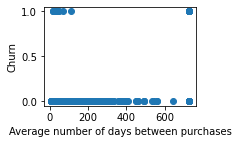

In [173]:
#Now another relevent topic when discussing this question
#We made this plot earlier
plt.subplot(2,2,2)
plt.scatter(df_churner4["Av_num_days_between_purchases"], df_churner4["Churn_binary"])
plt.xlabel("Average number of days between purchases")
plt.ylabel("Churn")
plt.show()

#We can see that when looking at Churners: they tend to buy very quickly and then "burn-out"
#We go deeper into this in Question 5.3
#But from this plot we can conclude that little time between purchases needs to be rewarded:
#You motivate spenders to spend more and are able to prevent Churn.
#Tracking quick spending behaviour between Customers is a lot of work and yield little results

#So our recommendation would be to offer reward programs: Loyalty cards that track purchases
#And offers discounts/other rewards when the customers buys alot between a certain by the firm
#Defined gap of time


In [ ]:
#Q5.2 Which employees should be rewarded?

In [ ]:
#Q5.3 To which customers should the company send coupons in order to win them back?

In [ ]:
#Q5.4 Are there factors that the company can change in order to decrease the churning rate?

In [ ]:
#Q5.5 Would it be valuable to recommend (upsell / cross sell) products to a customer?

In [ ]:
#Q5.6 Which employees should be assigned to different routes?

In [ ]:
#Q5.7 Which routes should be reassigned to different depots?

#### Q4.3 moet je zeker geladen hebben om de afbeelding van belgie
#in te putten, vergeet daar ook niet de directory te checken!!!!!!!!!!!!!!!!!!! 

###DEINZE###
kleuren_de = ["#7FFF00", "#FF1493", "#00FFFF", "#7FFFD4", "#458B74", "#E3CF57", "#FF00FF", "#000000", "#0000FF",
          "#8A2BE2", "#20B2AA", "#3D9140"]
#len(df_deinze["HVROUTETEMPLATE_NRID"].unique())
#There are 12 different routes in df_antwerpen so we make a list of 12 different colours

fig, ax = plt.subplots(figsize = (30,50))

#Here we will plot every customer in a different color based on their routes. 
it = 0
for i in df_deinze["HVROUTETEMPLATE_NRID"].unique():
    coord = df_deinze[df_deinze["HVROUTETEMPLATE_NRID"] == i]
    ax.scatter(coord.LONG, coord.LAT, zorder=1, alpha= 0.9, color = kleuren_de[it], s=5, label = i)
    it += 1
    
ax.set_title('Plotting aarschot routes')

ax.scatter(3.5235857,50.9875406, zorder = 1, c = "b", s=300)  #coordinaten deinze depot
ax.set_xlim(2.5681,6.0095)
ax.set_ylim(50.2121,51.4472)
ax.legend(markerscale = 15.0, prop={'size': 30})
ax.imshow(afb, zorder=0, extent = (2.5681,6.0095,50.2121,51.4472), aspect= 'equal')

#Here we clearly see 289414945 as a route that should shift towards vilvoord for example.

In [ ]:
###AARSCHOT###
kleuren_aa = ["#7FFF00", "#FF1493", "#3D9140", "#7FFFD4"]
#len(df_aarschot["HVROUTETEMPLATE_NRID"].unique())
#There are 4 different routes in df_antwerpen so we make a list of 4 different colours

fig, ax = plt.subplots(figsize = (30,50))

#Here we will plot every customer in a different color based on their routes. 
it = 0
for i in df_aarschot["HVROUTETEMPLATE_NRID"].unique():
    coord = df_aarschot[df_aarschot["HVROUTETEMPLATE_NRID"] == i]
    ax.scatter(coord.LONG, coord.LAT, zorder=1, alpha= 0.9, color = kleuren_aa[it], s=5, label = i)
    it += 1
    
ax.set_title('Plotting aarschot routes')

ax.scatter(4.8365218, 50.9859959, zorder = 1, c = "c", s=300)  #coordinaten aarschot depot
ax.set_xlim(2.5681,6.0095)
ax.set_ylim(50.2121,51.4472)
ax.legend(markerscale = 15.0, prop={'size': 30})
ax.imshow(afb, zorder=0, extent = (2.5681,6.0095,50.2121,51.4472), aspect= 'equal')

#conclusie hier kan zijn dat we alle routes verplaatsen (zie laatste stap vilvoorde voor meer info) 
#289663610, 289662608, 289658600, 289657598

In [ ]:
###ANTWERPEN###
kleuren_an = ["#7FFF00", "#FF1493", "#00FFFF", "#7FFFD4","#458B74", "#E3CF57", "#FF69B4", "#000000", "#0000FF"]
#len(df_antwerpen["HVROUTETEMPLATE_NRID"].unique())
#There are 9 different routes in df_antwerpen so we make a list of 9 different colours

fig, ax = plt.subplots(figsize = (30,50))

#Here we will plot every customer in a different color based on their routes. 
it = 0
for i in df_antwerpen["HVROUTETEMPLATE_NRID"].unique():
    coord = df_antwerpen[df_antwerpen["HVROUTETEMPLATE_NRID"] == i]
    ax.scatter(coord.LONG, coord.LAT, zorder=1, alpha= 0.9, color = kleuren_an[it], s=5, label = i)
    it += 1
    
ax.set_title('Plotting antwerpen routes')

ax.scatter(4.3997081,51.2211097, zorder = 1, c = "g", s=300)  #coordinaten antwerpen depot
ax.set_xlim(2.5681,6.0095)
ax.set_ylim(50.2121,51.4472)
ax.legend(markerscale = 15.0, prop={'size': 30})
ax.imshow(afb, zorder=0, extent = (2.5681,6.0095,50.2121,51.4472), aspect= 'equal')

#the plot shows us that the routes 219018687 should change to Deinze, and perhaps some of the customers from route 
#289762482 should switch to 289759476

In [ ]:
###VILVOORDE###
#For vilvoorde it's a bit different. All the customers that have Vilvoorde as their depots do have Vilvoorde as their nearest 
#depot. However some of these customers still have a great lenght between them and the depot. For these customers we would be
#able to design a new depot and transfer some of those routes. 
#If we plot all the customers based on their route_ID we can simply read which routes should be swapped. 



kleuren_v = ["#FF34B3", "#8B8378", "#00FFFF", "#6E6E6E","#458B74", "#E3CF57", "#FFE4C4", "#000000", "#0000FF",
          "#8A2BE2", "#FF3030", "#7FFF00", "#FF6103", "#3D9140"]
#len(df_vilvoorde["HVROUTETEMPLATE_NRID"].unique())
#There are 14 different routes in df_vilvoorde so we make a list of 14 different colours

fig, ax = plt.subplots(figsize = (30,50))

#Here we will plot every customer in a different color based on their routes. 
it = 0
for i in df_vilvoorde["HVROUTETEMPLATE_NRID"].unique():
    coord = df_vilvoorde[df_vilvoorde["HVROUTETEMPLATE_NRID"] == i]
    ax.scatter(coord.LONG, coord.LAT, zorder=1, alpha= 0.9, color = kleuren_v[it], s=5, label = i)
    it += 1
    
ax.set_title('Plotting vilvoore routes')

ax.scatter(4.4257868, 50.9272511, zorder = 1, c = "m", s=300)  #coordinaten vilvoorde depot
ax.set_xlim(2.5681,6.0095)
ax.set_ylim(50.2121,51.4472)
ax.legend(markerscale = 15.0, prop={'size': 30})
ax.imshow(afb, zorder=0, extent = (2.5681,6.0095,50.2121,51.4472), aspect= 'equal')

#We can clearly see that the four moest left clusters per route are routes number: 289413943 289411939 289419955 289418953

In [174]:
#Q5.8 Which customers should be reassigned to different routes?
#We're going to determine how far each customer is from his or her depot in order to determine a cutoff value
l = []
print(df_deinze)
for i in range(0,len(df_deinze)):
    loc1 = df_deinze.iloc[i,7],df_deinze.iloc[i,8]
    loc2 = (3.5235857,50.9875406)
    l.append(hs.haversine(loc1, loc2))
df_deinze["Distance2deinze"] = l

#Voor deinze hebben we een cutoff value van 60 km genomen, dit geeft ons 125 customers die beter van route zouden veranderen.
#Dit zijn de customer die beter door het Depot Vilvoorde zouden bediend worden. 
df_deinze[df_deinze["Distance2deinze"]>60]

       DEPOT  HVROUTETEMPLATE_NRID CustomerType     Customer_ID    CLV  \
0     Deinze             219020601      Private          721110  183.6   
1     Deinze             219020601      Private          721121   74.7   
2     Deinze             219020601      Private          721126  121.3   
3     Deinze             219020601      Private          721131  468.9   
4     Deinze             219020601      Private          721136  104.6   
...      ...                   ...          ...             ...    ...   
1476  Deinze             289757472      Private  25292960543250   34.8   
1477  Deinze             289757472      Private  25371544626642   37.6   
1478  Deinze             289757472      Private  25436952254040    0.0   
1479  Deinze             289757472      Private  25616776446438    7.1   
1480  Deinze              70671404     Catering  19672260568052   95.9   

          CustomerID REGION      LONG        LAT  
0             721110    C04  3.428621  50.813597  
1        

<ipython-input-174-af004fe9fa79>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deinze["Distance2deinze"] = l


DEPOT  HVROUTETEMPLATE_NRID CustomerType     Customer_ID     CLV  \
1204  Deinze             289414945      Private         1245116  140.85   
1205  Deinze             289414945      Private         1247147  196.90   
1206  Deinze             289414945      Private         1247154  303.80   
1207  Deinze             289414945      Private         1247159  128.10   
1208  Deinze             289414945      Private         1247170  255.70   
...      ...                   ...          ...             ...     ...   
1324  Deinze             289414945      Private  21984056122238  205.00   
1325  Deinze             289414945      Private  22595676546246  299.00   
1326  Deinze             289414945      Private  22626880347042  206.00   
1327  Deinze             289414945      Private  23214964682252   28.30   
1328  Deinze             289414945      Private  25783568436840   90.50   

          CustomerID REGION      LONG        LAT  Distance2deinze  
1204         1245116    B02  4.091474  50.512913        82.222271  
1205         1247147    B02  4.116896  50.476648        86.978918  
1206         1247154    B02  4.116869  50.477956        86.882161  
1207         1247159    B02  4.116920  50.475459        87.066997  
1208         1247170    B02  4.116903  50.476292        87.005340  
...              ...    ...       ...        ...              ...  
1324  21984056122238    B02  4.063176  50.514655        79.704279  
1325  22595676546246    B02  4.063176  50.514655        79.704279  
1326  22626880347042    B02  4.090801  50.530144        80.952788  
1327  23214964682252    B02  4.124422  50.488983        86.736172  
1328  25783568436840    B02  4.054881  50.509307        79.407718  

[125 rows x 10 columns]

In [175]:
k = list()
for i in range(0,len(df_aarschot)):
    locA = df_aarschot.iloc[i,7],df_aarschot.iloc[i,8] #LONG en LAT zijn hier de 5e en 6e index kolom, indien niet ->aanpassen!
    locB = (4.3997081, 51.2211097)
    locB = (4.8365218, 50.9859959)
    k.append(hs.haversine(locA,locB))
df_aarschot["Distance2aarschot"] = k

#Voor aarschot hebben we een cutoff value van 50 km genomen, dit geeft ons 453 customers die beter van route zouden veranderen.
#Hier is de cutoff nogal nutteloos omdat elke klant nogal ver ligt, eigenlijk zouden alle klanten moeten switchen of nog beter
#is het depot verplaatsen!
df_aarschot[df_aarschot["Distance2aarschot"]>50]

<ipython-input-175-60b99d2f5c79>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aarschot["Distance2aarschot"] = k


DEPOT  HVROUTETEMPLATE_NRID CustomerType     Customer_ID      CLV  \
4888  Aarschot             289663610       Horeca         1403452  3056.15   
4889  Aarschot             289663610      Private         1403634    63.90   
4890  Aarschot             289663610      Private         1404652    87.30   
4891  Aarschot             289663610      Private         1404657    74.70   
4892  Aarschot             289663610      Private         1404836    77.60   
...        ...                   ...          ...             ...      ...   
5408  Aarschot             289657598      Private  22984388586446   143.40   
5409  Aarschot             289657598      Private  23046160476440    24.40   
5410  Aarschot             289657598      Private  23094676615642   294.80   
5411  Aarschot             289657598      Private  23212860542648    47.30   
5412  Aarschot             289657598      Private  23241560632648   106.50   

          CustomerID REGION      LONG        LAT  Distance2aarschot  
4888         1403452    C17  4.519567  50.579854          57.166972  
4889         1403634    C17  4.540880  50.560831          57.452584  
4890         1404652    C17  4.538370  50.543430          59.200386  
4891         1404657    C17  4.543427  50.547195          58.540066  
4892         1404836    C17  4.535472  50.552832          58.523814  
...              ...    ...       ...        ...                ...  
5408  22984388586446    C17  4.482583  50.608320          57.453560  
5409  23046160476440    C17  4.482845  50.606038          57.618180  
5410  23094676615642    C17  4.574675  50.578927          53.691629  
5411  23212860542648    C17  4.559354  50.576631          54.844878  
5412  23241560632648    C17  4.478253  50.609375          57.699908  

[434 rows x 10 columns]

In [176]:
k = list()
for i in range(0,len(df_antwerpen)):
    locA = df_antwerpen.iloc[i,7],df_antwerpen.iloc[i,8] #LONG en LAT zijn hier de 5e en 6e index kolom, indien niet ->aanpassen!
    locB = (4.3997081, 51.2211097)
    k.append(hs.haversine(locA,locB))
df_antwerpen["Distance2antwerpen"] = k

#De cutoff is hier ook 60 km, dat zorgt er voor dat de groep customers uit regio de pinte wegvallen maar alle andere customers
#er nog blijven. Dat groepje zou beter aansluiten aan de routes van Deinze.
df_antwerpen[df_antwerpen["Distance2antwerpen"]>60]

<ipython-input-176-e687cc17f2e0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_antwerpen["Distance2antwerpen"] = k


DEPOT  HVROUTETEMPLATE_NRID CustomerType     Customer_ID      CLV  \
1481  Antwerpen             219018687      Private          718230   236.20   
1482  Antwerpen             219018687      Private          718236   127.50   
1483  Antwerpen             219018687      Private          718247    42.60   
1484  Antwerpen             219018687      Private          718257   281.80   
1485  Antwerpen             219018687      Private          718263   357.80   
...         ...                   ...          ...             ...      ...   
2081  Antwerpen             289759476      Private  22691648376246    78.60   
2083  Antwerpen             289759476       Horeca  23392360633650   518.50   
2396  Antwerpen             289762482       Horeca         1451799  9938.90   
2433  Antwerpen             289762482      Private        62126098   105.10   
2451  Antwerpen             289762482      Private         1455963   271.15   

          CustomerID REGION      LONG        LAT  Distance2antwerpen  
1481          718230    C04  3.708606  50.980740           81.340586  
1482          718236    C04  3.712480  50.977313           81.059729  
1483          718247    C04  3.717360  50.971535           80.765768  
1484          718257    C04  3.717471  50.967531           80.907416  
1485          718263    C04  3.717015  50.965532           81.032336  
...              ...    ...       ...        ...                 ...  
2081  22691648376246    B25  3.784532  51.370611           70.385526  
2083  23392360633650    B25  3.784532  51.370611           70.385526  
2396         1451799    B25  3.788805  51.369897           69.905117  
2433        62126098    B25  3.784532  51.370611           70.385526  
2451         1455963    B25  3.784532  51.370611           70.385526  

[204 rows x 10 columns]

In [ ]:
#voor vilvoorde is er geen reden om een cutoff te bepalen aangezien er geen groepen customers 
#uitzonderlijk ver liggen van het depot.

In [41]:
#Q5.9 Which depots should be removed? Where should the company create new depots?
#If we look at our plotted map of Belgium:
#Based on the number of customers and the distance, the depot in Aarschot should be removed. 
#It is not located very close to the centre of any cluster of customers.

#By opening a new depot that in the region Geraardsbergen - Ninove - Enghien you would be able to serve all clusters even more
#without traveling a very large distance. 

#Potentially we can ope a depot more south near Charleroi to decreaese the large pressure on the Depot in vilvoorde

In [ ]:
#Q5.10 Which products should be added / removed from depots?

count    5112.000000
mean       62.695618
std        20.341462
min         0.000000
25%        50.000000
50%        75.000000
75%        75.000000
max       100.000000
Name: reviewScorePercentage, dtype: float64


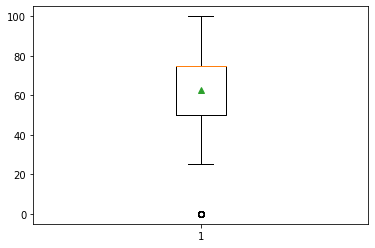

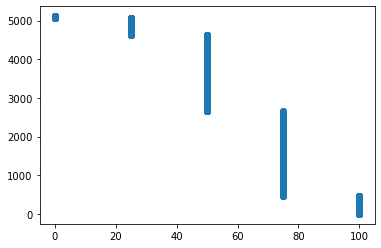

In [290]:
#Q5.11 Does customer satisfaction relate to different factors? Can the company respond to these
#factors?

#Firstly we take the Reviews dataframe containing the review score and the customer_ID
#And turn the str review into a score 
def reviewScore(review: str):
    if(review == "Excellent service, very satisfied"):
        return 4
    elif(review == "Good service, satisfied"):
        return 3
    elif(review == "No opinion"):
        return 2
    elif(review == "Not completely satisfied"):
        return 1
    else:
        return 0
def getScorePercentage(review: int):
    return (review/4)*100
#Using this function we can determine how satisfied customers are overall:
#We use a reviewScore from 0 to 4 and express it in a percentage for clarity
#by divinding these scores by 4 and multiplying them with 100

#We apply both these functions and store the results in new columns
#In the reviews data frame
df_Reviews["reviewScore"]=df_Reviews["Review"].apply(reviewScore)
df_Reviews["reviewScorePercentage"]=df_Reviews["reviewScore"].apply(getScorePercentage)
df_Reviews=df_Reviews.sort_values(by="reviewScore", ascending=False)

#We can see that in total we have 5112 reviews and use describe to get other statistics
print(df_Reviews["reviewScorePercentage"].describe())

#The company gets a 6.3/10 on average
#These are not the best review scores but are postive/good 
plt.boxplot(df_Reviews["reviewScorePercentage"],showmeans=True)
plt.show()

#The boxplot show a healthy behaviour. Nicely centered around this mean of 62.7 percent
#and having a std of roughly 20.34 at both sides
plt.scatter(df_Reviews["reviewScorePercentage"],range(0,len(df_Reviews)))
plt.show()

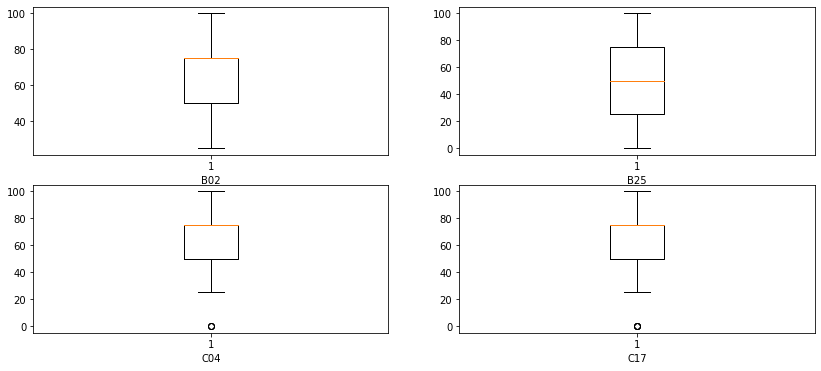

In [291]:
#Now we will look at the different reviews scores around different regions
df_Reviews["Customer_ID"]=df_Reviews.index

#First we merge dataframes in order to get information of the customers linked to the review
df_CleanedCustomerType = df_CustomerType.drop(columns=["CLV","CustomerID","Season"])
df_ReviewCust = pd.merge(df_Reviews,df_CleanedCustomerType, on="Customer_ID",how="left")
#Next we merge with the routes they are assinged to, to get the region and other descriptors
df_ReviewCustLoc = pd.merge(df_ReviewCust,df_RouteTemplate, on="RouteTemplate_ID",how="left").dropna()

#We have the following Regions: BO2, C17, C04, B25
#print(df_ReviewCustLoc["REGION"].unique())
df_ReviewB02 = df_ReviewCustLoc[df_ReviewCustLoc["REGION"]=="B02"]
df_ReviewC17 = df_ReviewCustLoc[df_ReviewCustLoc["REGION"]=="C17"]
df_ReviewC04 = df_ReviewCustLoc[df_ReviewCustLoc["REGION"]=="C04"]
df_ReviewB25 = df_ReviewCustLoc[df_ReviewCustLoc["REGION"]=="B25"]

#print("B02:",df_ReviewB02["reviewScorePercentage"].describe())
#print("C17:",df_ReviewC17["reviewScorePercentage"].describe())
#print("C04:",df_ReviewC04["reviewScorePercentage"].describe()) 
#print("B25:",df_ReviewB25["reviewScorePercentage"].describe()) 

#Comparing these regions
plt.figure(figsize=(14,6))
plt.subplot(2,2,1)
plt.boxplot(df_ReviewB02["reviewScorePercentage"])
plt.xlabel("B02")
plt.subplot(2,2,2)
plt.boxplot(df_ReviewB25["reviewScorePercentage"])
plt.xlabel("B25")
plt.subplot(2,2,3)
plt.boxplot(df_ReviewC04["reviewScorePercentage"])
plt.xlabel("C04")
plt.subplot(2,2,4)
plt.boxplot(df_ReviewC17["reviewScorePercentage"],)
plt.xlabel("C17")

plt.show()


#We can see on the given plots differences between regions and add the statistics descriptions 
#All regions have about the same statistics besides B25: a mean of around 66/69 out of 100
#with about the same std dev of 18
#The biggest insight however is that region B25 responds poorly 
#Having a mean of 52.3 percent which is very close to no opinion: while the others are closer to good/satisfied
#On top of that results are varying more with a std of 22.519

#It is clear to see something went wrong in Region B25 as the amount of reviews
#Are about the same for every single region

Text(0.5, 0, 'French')

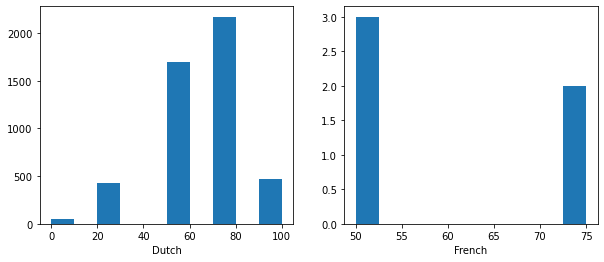

In [289]:
#We Look at the factor Language
df_ReviewCustLocNL = df_ReviewCustLoc[df_ReviewCustLoc["Language"]=="nl-BE"].drop(columns=["Postcode","CustomerType","RouteTemplate_ID","Customer_ID","DAYOFWEEK_NRID","WEEKORDER","REGION"])
df_ReviewCustLocFR = df_ReviewCustLoc[df_ReviewCustLoc["Language"]=="fr-BE"].drop(columns=["Postcode","CustomerType","RouteTemplate_ID","Customer_ID","DAYOFWEEK_NRID","WEEKORDER","REGION"])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df_ReviewCustLocNL["reviewScorePercentage"])
plt.xlabel("Dutch")

plt.subplot(1,2,2)
plt.hist(df_ReviewCustLocFR["reviewScorePercentage"])
plt.xlabel("French")

#There are only 5 reviews for french speakers so we omit this as a possible factor

4719


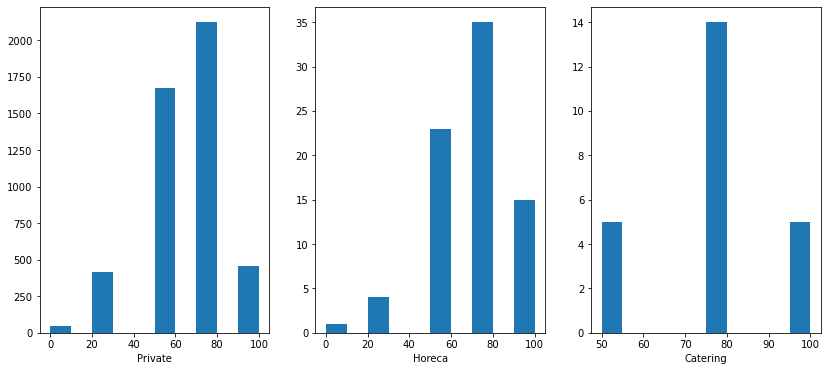

In [288]:
#Look at CustomerType
df_ReviewCustLocPrivate = df_ReviewCustLoc[df_ReviewCustLoc["CustomerType"]=="Private"].drop(columns=["Postcode","Language","RouteTemplate_ID","Customer_ID","DAYOFWEEK_NRID","WEEKORDER","REGION"])
df_ReviewCustLocHoreca = df_ReviewCustLoc[df_ReviewCustLoc["CustomerType"]=="Horeca"].drop(columns=["Postcode","Language","RouteTemplate_ID","Customer_ID","DAYOFWEEK_NRID","WEEKORDER","REGION"])
df_ReviewCustLocCatering = df_ReviewCustLoc[df_ReviewCustLoc["CustomerType"]=="Catering"].drop(columns=["Postcode","Language","RouteTemplate_ID","Customer_ID","DAYOFWEEK_NRID","WEEKORDER","REGION"])

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.hist(df_ReviewCustLocPrivate["reviewScorePercentage"])
plt.xlabel("Private")

plt.subplot(1,3,2)
plt.hist(df_ReviewCustLocHoreca["reviewScorePercentage"])
plt.xlabel("Horeca")

plt.subplot(1,3,3)
plt.hist(df_ReviewCustLocCatering["reviewScorePercentage"])
plt.xlabel("Catering")

#The plot of catering only has a set of 24 reviews and 
#Horeca 74, while there are 4719 private reviews: No conclusions can be drawn
#Test groups are too small

